In [1]:
%%configure

{
    "conf": {
        "spark.driver.maxResultSize": "8g",
        "spark.driver.memory": "54g",
        "spark.driver.cores": 8,
        "spark.executor.instances": 0,
        "spark.sql.execution.arrow.pyspark.enabled": "true",
        "spark.sql.execution.arrow.pyspark.selfDestruct.enabled": "true"
    }
}

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, -1, Finished, Available, Finished)

In [2]:
# Instalacao de pacote para uso de Target/CountEncoder
!pip install scikit-learn==1.3.2
!pip install category-encoders==2.6.3

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 3, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nni 3.0 requires filelock<3.12, but you have filelock 3.13.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.2 MB/s eta 0:00:00


# Estudo de Publico-Alvo — Clientes Claro (PRE -> CONTROLE)

**Hackathon PoD Academy — Claro + Oracle | Entregavel A**

---

### Contexto

Analise exploratoria do publico-alvo do modelo de credit risk (First Payment Default — FPD) para clientes Claro em migracao PRE -> CONTROLE.

- **Base**: `Gold.feature_store.clientes_consolidado`
- **Registros**: ~3.9M
- **Features**: 468 variaveis (102 recarga + 154 pagamento + 108 faturamento + ~103 cadastro/telco/target)
- **SAFRAs**: 202410 a 202503 (6 periodos)
- **Target**: `FPD` (First Payment Default) — 0/1
- **Granularidade**: `NUM_CPF` x `SAFRA`

### Objetivo

Caracterizar o perfil dos clientes inadimplentes (FPD=1) vs adimplentes (FPD=0) atraves de:
1. Distribuicao do target por SAFRA
2. Perfil demografico e cadastral
3. Segmentacao de risco (scores operacionais)
4. Comportamento de recarga
5. Comportamento de pagamento
6. Comportamento de faturamento
7. Perfil de migracao PRE -> CONTROLE
8. Correlacao com target
9. Insights e conclusoes

In [3]:
# ==============================================================================
# SETUP — Imports, Config, Carregamento de Dados
# ==============================================================================

import sys; sys.path.insert(0, "/lakehouse/default/Files/projeto-final")
from config.pipeline_config import GOLD_BASE, PATH_FEATURE_STORE

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType

# Estilo
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 150, "savefig.dpi": 150, "figure.facecolor": "white"})

# Diretorio de saida para figuras
FIG_DIR = "/lakehouse/default/Files/projeto-final/docs/analytics"

# Garantir que o diretorio existe
import os
os.makedirs(FIG_DIR, exist_ok=True)

# Carregar feature store consolidada
df = spark.read.format("delta").load(PATH_FEATURE_STORE)

total_registros = df.count()
total_features = len(df.columns)
safras_list = sorted([r.SAFRA for r in df.select("SAFRA").distinct().collect()])

print(f"Registros: {total_registros:,}")
print(f"Features:  {total_features}")
print(f"SAFRAs:    {safras_list}")
print(f"Colunas target: FPD, TARGET_SCORE_01, TARGET_SCORE_02")
print(f"\nPrefixos de features:")
print(f"  REC_* (recarga):     {len([c for c in df.columns if c.startswith('REC_')])} vars")
print(f"  PAG_* (pagamento):   {len([c for c in df.columns if c.startswith('PAG_')])} vars")
print(f"  FAT_* (faturamento): {len([c for c in df.columns if c.startswith('FAT_')])} vars")
print(f"  Cadastro/Telco/Outros: {total_features - len([c for c in df.columns if c.startswith(('REC_','PAG_','FAT_'))])} vars")

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 4, Finished, Available, Finished)

Registros: 3,900,378
Features:  402
SAFRAs:    [202410, 202411, 202412, 202501, 202502, 202503]
Colunas target: FPD, TARGET_SCORE_01, TARGET_SCORE_02

Prefixos de features:
  REC_* (recarga):     90 vars
  PAG_* (pagamento):   94 vars
  FAT_* (faturamento): 114 vars
  Cadastro/Telco/Outros: 104 vars


## 1. Distribuicao do Target (FPD)

Analise da variavel target **First Payment Default (FPD)** — indica se o cliente deixou de pagar a primeira fatura apos migracao para plano controle.

- **FPD = 0**: Adimplente (pagou a primeira fatura)
- **FPD = 1**: Inadimplente (nao pagou)
- **FPD = null**: Clientes sem fatura maturada (excluidos da modelagem)

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 5, Finished, Available, Finished)

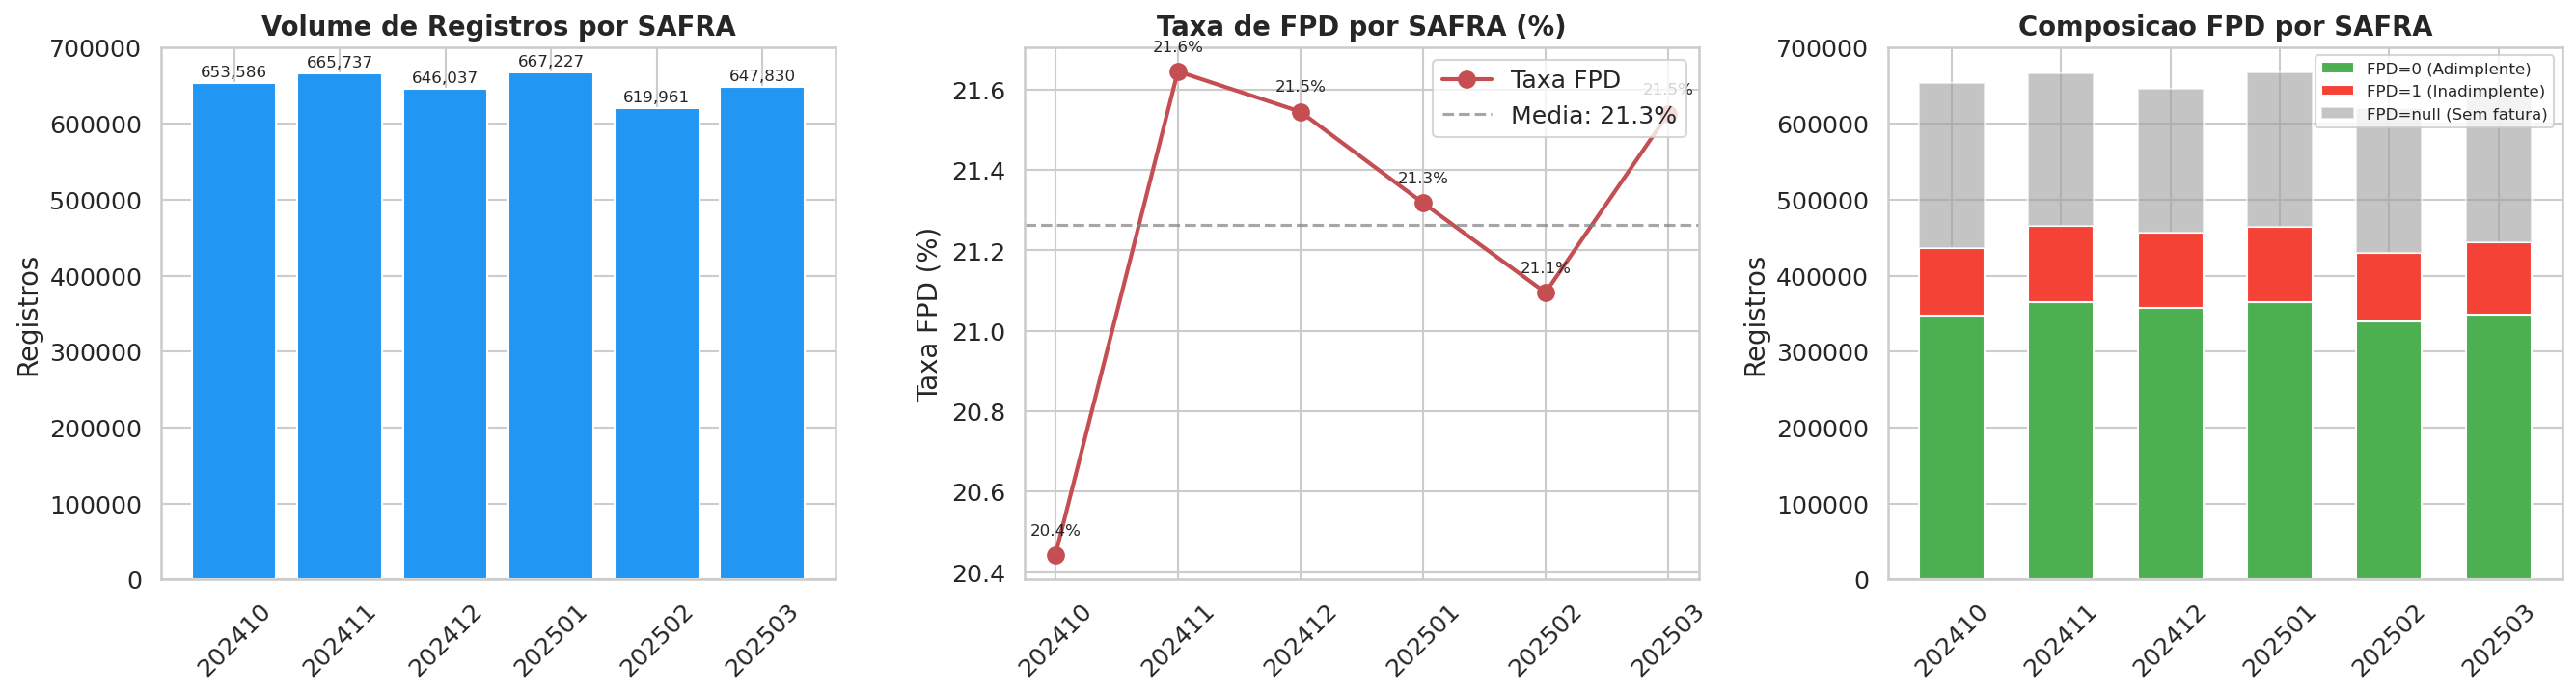


=== Distribuicao FPD por SAFRA ===
 SAFRA  total  fpd_1  fpd_0  fpd_null  taxa_fpd
202410 653586  89205 347183    217198  0.204417
202411 665737 100835 365015    199887  0.216454
202412 646037  98319 358021    189697  0.215451
202501 667227  98847 364826    203554  0.213183
202502 619961  90723 339341    189897  0.210952
202503 647830  95701 348605    203524  0.215394


In [4]:
# ==============================================================================
# FIG 01 — Distribuicao FPD por SAFRA (volume + taxa)
# ==============================================================================

fpd_by_safra = df.groupBy("SAFRA").agg(
    F.count("*").alias("total"),
    F.sum(F.when(F.col("FPD") == 1, 1).otherwise(0)).alias("fpd_1"),
    F.sum(F.when(F.col("FPD") == 0, 1).otherwise(0)).alias("fpd_0"),
    F.sum(F.when(F.col("FPD").isNull(), 1).otherwise(0)).alias("fpd_null"),
    F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
).orderBy("SAFRA").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Volume por SAFRA
bars = axes[0].bar(fpd_by_safra["SAFRA"].astype(str), fpd_by_safra["total"], color="#2196F3", edgecolor="white")
axes[0].set_title("Volume de Registros por SAFRA", fontweight="bold")
axes[0].set_ylabel("Registros")
axes[0].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, fpd_by_safra["total"]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
                 f"{val:,.0f}", ha="center", va="bottom", fontsize=8)

# Subplot 2: Taxa FPD por SAFRA
axes[1].plot(fpd_by_safra["SAFRA"].astype(str), fpd_by_safra["taxa_fpd"]*100,
             'ro-', linewidth=2, markersize=8, label="Taxa FPD")
axes[1].set_title("Taxa de FPD por SAFRA (%)", fontweight="bold")
axes[1].set_ylabel("Taxa FPD (%)")
axes[1].tick_params(axis='x', rotation=45)
media_fpd = fpd_by_safra["taxa_fpd"].mean() * 100
axes[1].axhline(y=media_fpd, color='gray', linestyle='--', alpha=0.7, label=f'Media: {media_fpd:.1f}%')
axes[1].legend(loc="upper right")
for i, row in fpd_by_safra.iterrows():
    if pd.notna(row["taxa_fpd"]):
        axes[1].annotate(f"{row['taxa_fpd']*100:.1f}%",
                         (str(int(row['SAFRA'])), row['taxa_fpd']*100),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

# Subplot 3: Composicao FPD (stacked)
x = np.arange(len(fpd_by_safra))
width = 0.6
axes[2].bar(x, fpd_by_safra["fpd_0"], width, label="FPD=0 (Adimplente)", color="#4CAF50")
axes[2].bar(x, fpd_by_safra["fpd_1"], width, bottom=fpd_by_safra["fpd_0"],
            label="FPD=1 (Inadimplente)", color="#F44336")
axes[2].bar(x, fpd_by_safra["fpd_null"], width,
            bottom=fpd_by_safra["fpd_0"] + fpd_by_safra["fpd_1"],
            label="FPD=null (Sem fatura)", color="#9E9E9E", alpha=0.6)
axes[2].set_xticks(x)
axes[2].set_xticklabels(fpd_by_safra["SAFRA"].astype(str), rotation=45)
axes[2].set_title("Composicao FPD por SAFRA", fontweight="bold")
axes[2].set_ylabel("Registros")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/fig01_fpd_por_safra.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n=== Distribuicao FPD por SAFRA ===")
print(fpd_by_safra.to_string(index=False))

## 2. Perfil Demografico

Analise das variaveis cadastrais dos clientes:
- **var_03**: Codigo UF (1-100, encoded)
- **var_04**: Faixa etaria (categorias encoded)
- **var_05**: Score de comportamento (1-10)
- **PROD**: Produto (CMV, NET, DTH)
- **flag_mig2**: Tipo migracao (Aquisicao, PRE, FLEX)
- **STATUSRF**: Status Receita Federal

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 6, Finished, Available, Finished)

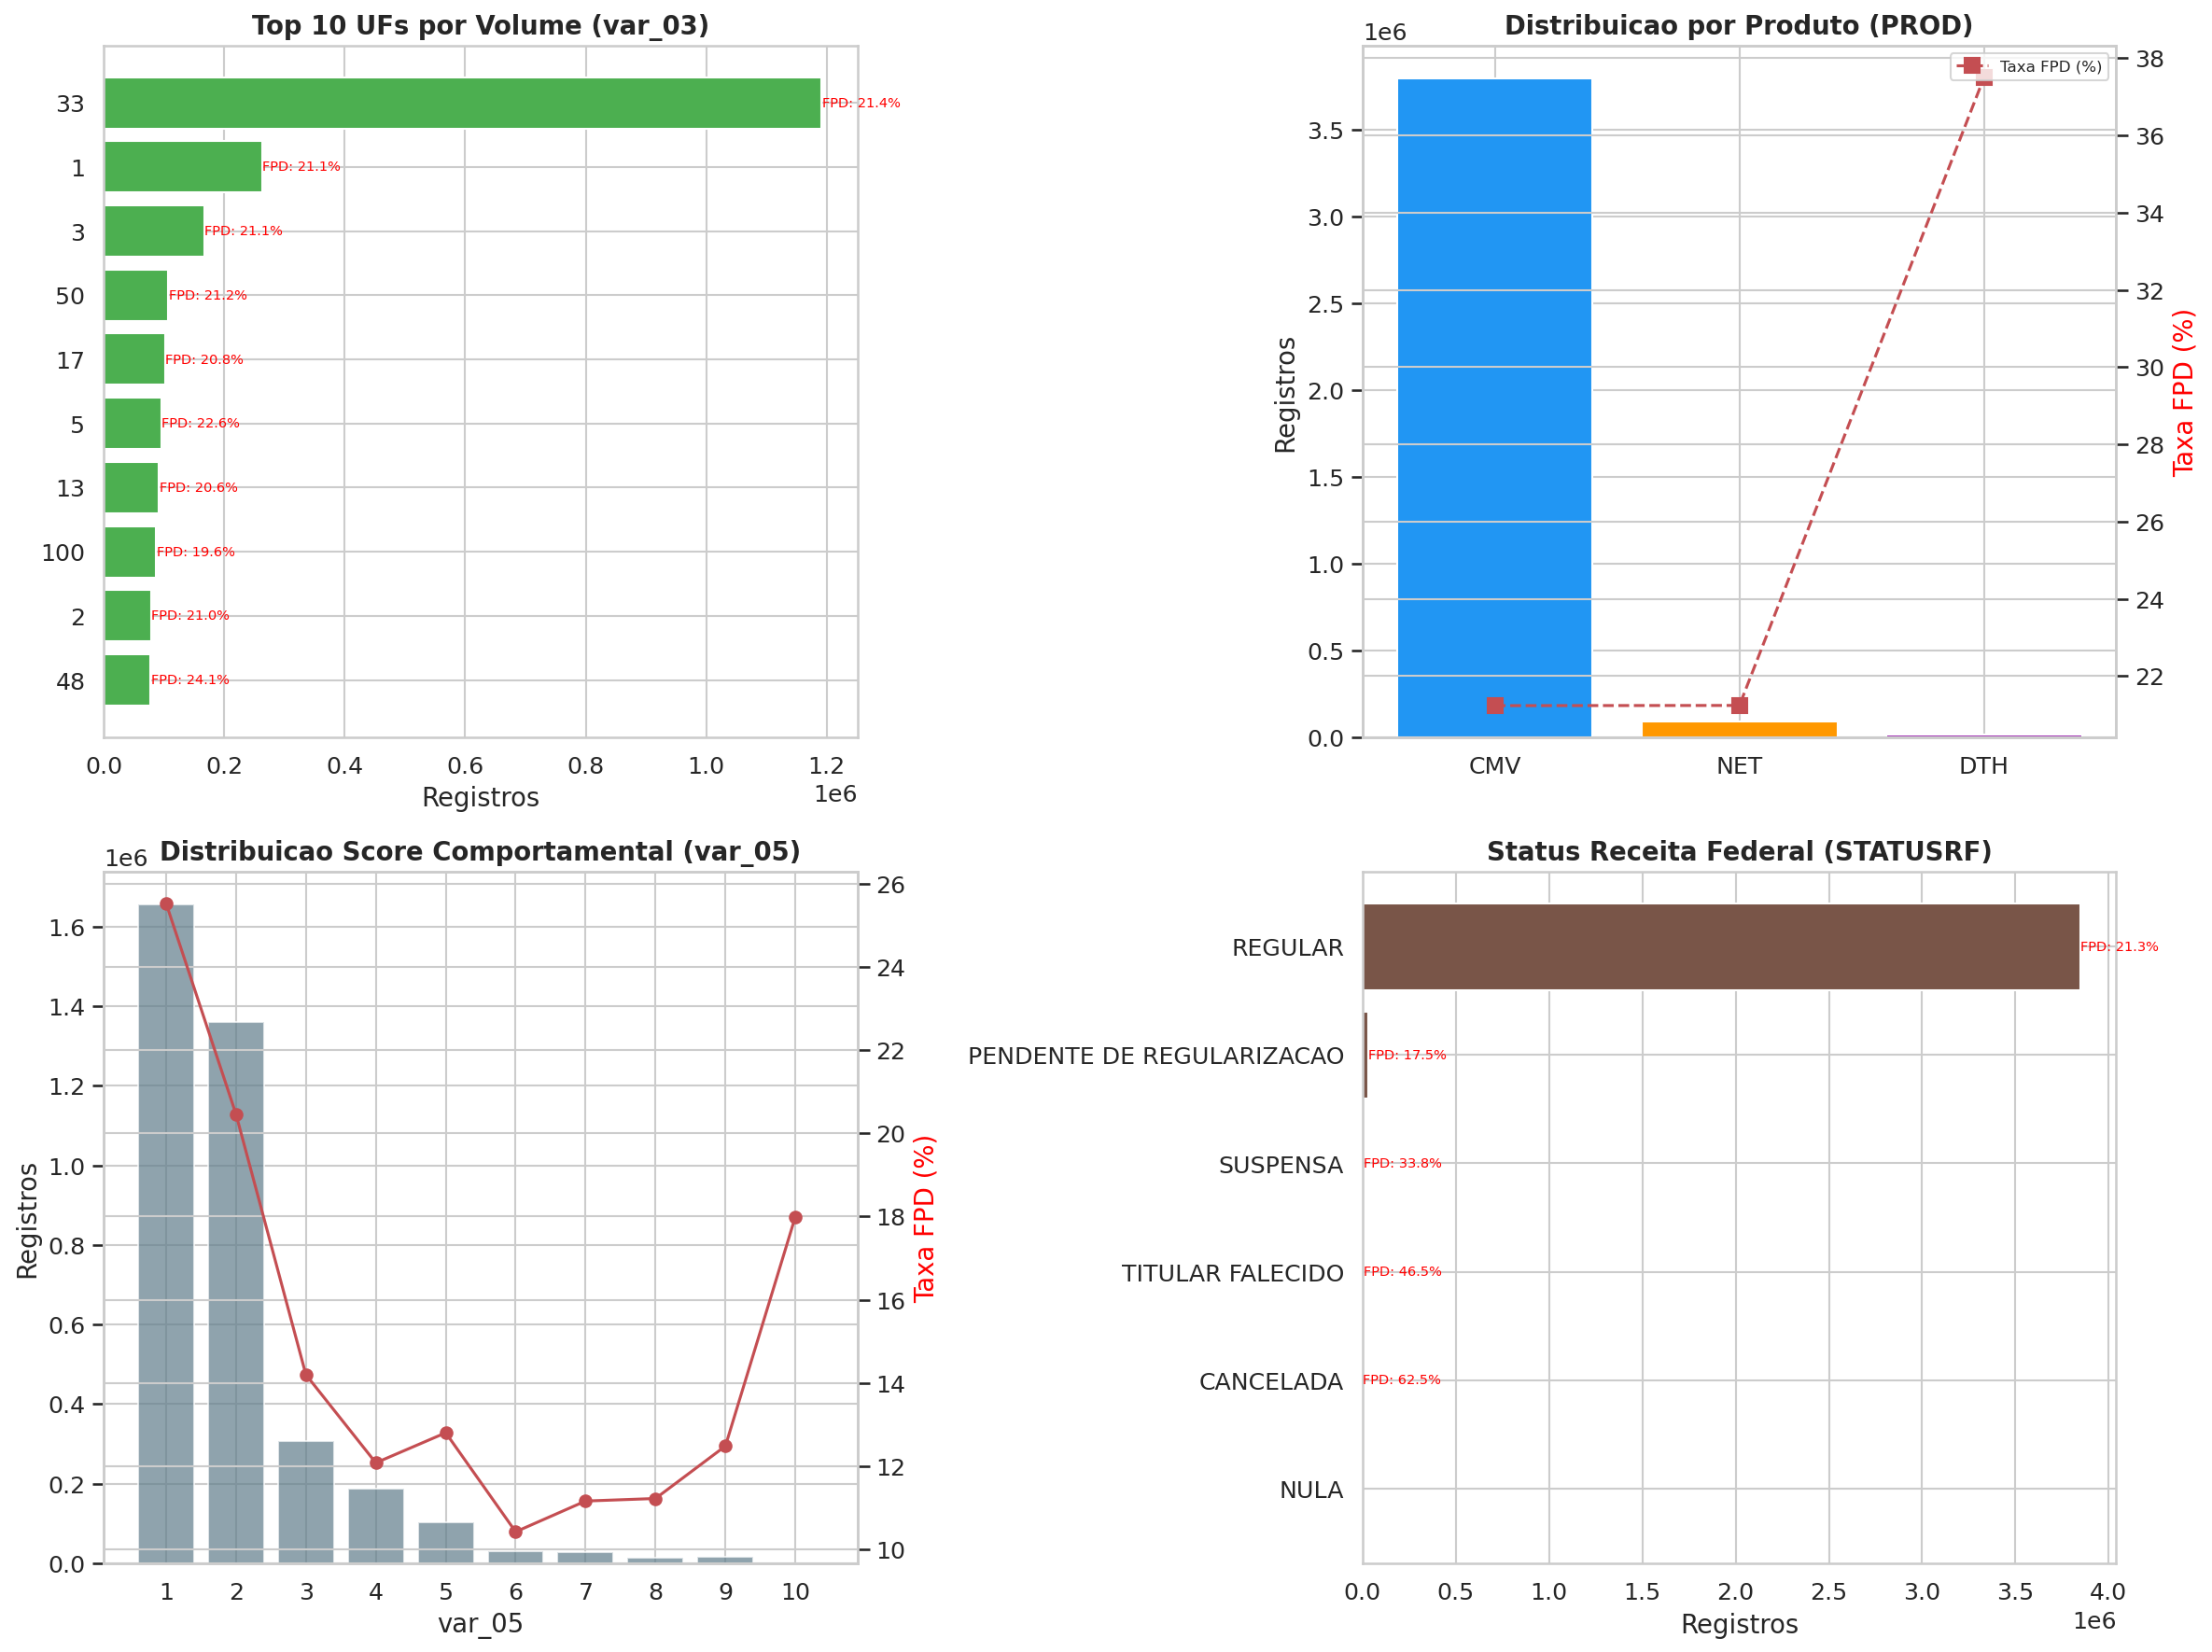

In [5]:
# ==============================================================================
# FIG 02 — Perfil Demografico (4 subplots)
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 2a: Top 10 UFs (var_03) por volume ---
try:
    uf_dist = df.filter(F.col("var_03").isNotNull()).groupBy("var_03").agg(
        F.count("*").alias("total"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy(F.desc("total")).limit(10).toPandas()

    bars = axes[0,0].barh(uf_dist["var_03"].astype(str), uf_dist["total"], color="#4CAF50", edgecolor="white")
    axes[0,0].set_title("Top 10 UFs por Volume (var_03)", fontweight="bold")
    axes[0,0].set_xlabel("Registros")
    axes[0,0].invert_yaxis()
    # Annotate taxa FPD
    for bar, taxa in zip(bars, uf_dist["taxa_fpd"]):
        if pd.notna(taxa):
            axes[0,0].text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2,
                           f"FPD: {taxa*100:.1f}%", va="center", fontsize=7, color="red")
except Exception as e:
    axes[0,0].text(0.5, 0.5, f"var_03 indisponivel\n{e}", transform=axes[0,0].transAxes, ha="center")

# --- 2b: Distribuicao por Produto (PROD) ---
try:
    prod_dist = df.filter(F.col("PROD").isNotNull()).groupBy("PROD").agg(
        F.count("*").alias("total"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy(F.desc("total")).toPandas()

    x_pos = np.arange(len(prod_dist))
    bars = axes[0,1].bar(x_pos, prod_dist["total"], color=["#2196F3", "#FF9800", "#9C27B0"][:len(prod_dist)])
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(prod_dist["PROD"])
    axes[0,1].set_title("Distribuicao por Produto (PROD)", fontweight="bold")
    axes[0,1].set_ylabel("Registros")
    ax2 = axes[0,1].twinx()
    ax2.plot(x_pos, prod_dist["taxa_fpd"]*100, 'rs--', markersize=8, label="Taxa FPD (%)")
    ax2.set_ylabel("Taxa FPD (%)", color="red")
    ax2.legend(loc="upper right", fontsize=8)
except Exception as e:
    axes[0,1].text(0.5, 0.5, f"PROD indisponivel\n{e}", transform=axes[0,1].transAxes, ha="center")

# --- 2c: Distribuicao var_05 (score comportamento) ---
try:
    var05_dist = df.filter(F.col("var_05").isNotNull()).groupBy("var_05").agg(
        F.count("*").alias("total"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy("var_05").toPandas()

    axes[1,0].bar(var05_dist["var_05"].astype(str), var05_dist["total"], color="#607D8B", alpha=0.7)
    axes[1,0].set_title("Distribuicao Score Comportamental (var_05)", fontweight="bold")
    axes[1,0].set_xlabel("var_05")
    axes[1,0].set_ylabel("Registros")
    ax2 = axes[1,0].twinx()
    ax2.plot(var05_dist["var_05"].astype(str), var05_dist["taxa_fpd"]*100, 'ro-', markersize=6)
    ax2.set_ylabel("Taxa FPD (%)", color="red")
except Exception as e:
    axes[1,0].text(0.5, 0.5, f"var_05 indisponivel\n{e}", transform=axes[1,0].transAxes, ha="center")

# --- 2d: Status Receita Federal (STATUSRF) ---
try:
    status_dist = df.filter(F.col("STATUSRF").isNotNull()).groupBy("STATUSRF").agg(
        F.count("*").alias("total"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy(F.desc("total")).toPandas()

    bars = axes[1,1].barh(status_dist["STATUSRF"], status_dist["total"], color="#795548")
    axes[1,1].set_title("Status Receita Federal (STATUSRF)", fontweight="bold")
    axes[1,1].set_xlabel("Registros")
    axes[1,1].invert_yaxis()
    for bar, taxa in zip(bars, status_dist["taxa_fpd"]):
        if pd.notna(taxa):
            axes[1,1].text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2,
                           f"FPD: {taxa*100:.1f}%", va="center", fontsize=7, color="red")
except Exception as e:
    axes[1,1].text(0.5, 0.5, f"STATUSRF indisponivel\n{e}", transform=axes[1,1].transAxes, ha="center")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/fig02_perfil_demografico.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Segmentacao de Risco

Os books de features calculam um **SCORE_RISCO** (0-100) para cada dominio:
- `REC_SCORE_RISCO`: Baseado em comportamento de recarga (SOS, variabilidade, frequencia)
- `PAG_SCORE_RISCO`: Baseado em pagamentos (juros, status, concentracao)
- `FAT_SCORE_RISCO`: Baseado em faturamento (WO, PDD, atraso, inadimplencia)

Estes scores sao indicadores operacionais e **NAO representam data leakage** (validado em Story 1.1).

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 7, Finished, Available, Finished)

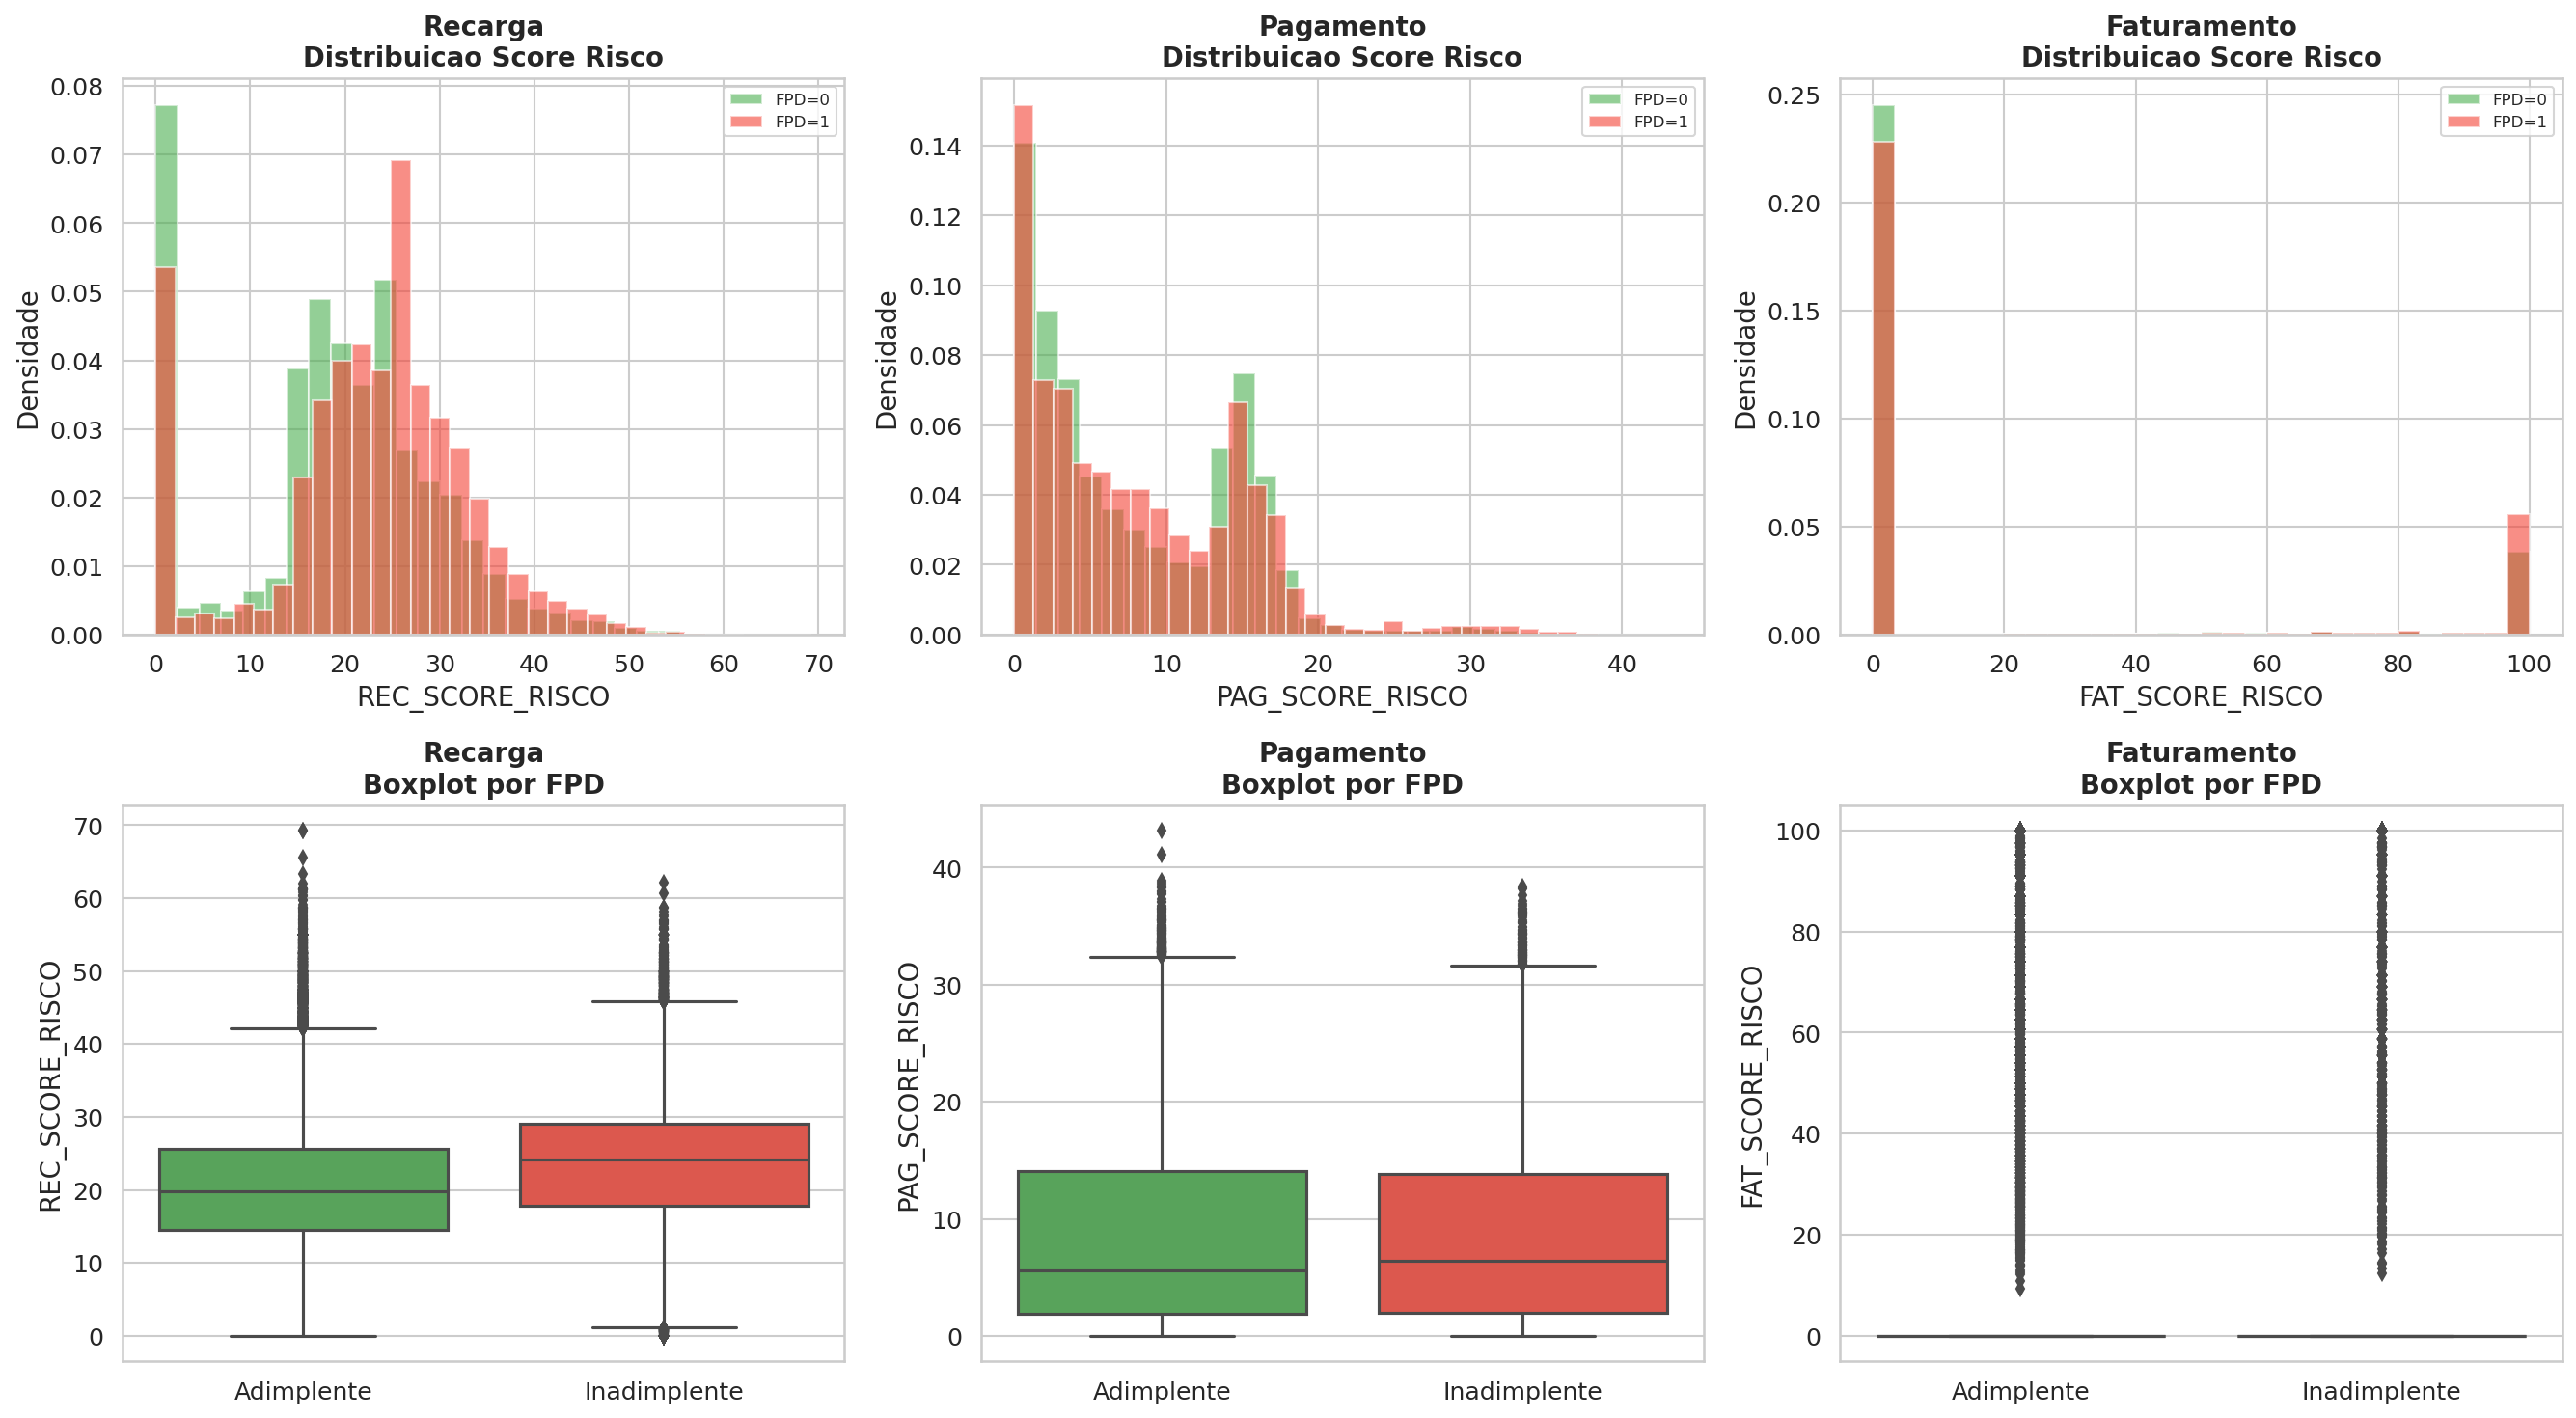


=== Estatisticas Score Risco por FPD ===

Recarga (REC_SCORE_RISCO):
 FPD     media    desvio   mediana
   0 18.876482 11.400688 19.902055
   1 22.441758 10.968677 24.107306

Pagamento (PAG_SCORE_RISCO):
 FPD    media   desvio  mediana
   0 7.725198 6.595070 5.611433
   1 8.014886 6.914611 6.440582

Faturamento (FAT_SCORE_RISCO):
 FPD     media    desvio  mediana
   0 16.357930 35.506758      0.0
   1 21.995923 40.121322      0.0


In [6]:
# ==============================================================================
# FIG 03 — Score de Risco por Book vs FPD (histograms + boxplots)
# ==============================================================================

score_cols = [
    ("REC_SCORE_RISCO", "Recarga", "#4CAF50"),
    ("PAG_SCORE_RISCO", "Pagamento", "#2196F3"),
    ("FAT_SCORE_RISCO", "Faturamento", "#FF9800"),
]

# Verificar quais colunas existem
available_scores = [(col, label, color) for col, label, color in score_cols if col in df.columns]

if available_scores:
    n_scores = len(available_scores)
    fig, axes = plt.subplots(2, n_scores, figsize=(6 * n_scores, 10))
    if n_scores == 1:
        axes = axes.reshape(2, 1)

    # Amostra para plot (maximo 500k registros para performance)
    sample_cols = ["FPD"] + [c for c, _, _ in available_scores]
    df_sample = df.select(sample_cols).filter(F.col("FPD").isNotNull()).sample(False, 0.1, seed=42).toPandas()

    # Converter Decimal para float (Delta Lake retorna decimal.Decimal)
    for c in sample_cols:
        if c != "FPD":
            df_sample[c] = pd.to_numeric(df_sample[c], errors="coerce")

    for i, (col, label, color) in enumerate(available_scores):
        # Row 1: Histograma por FPD
        for fpd_val, fpd_color, fpd_label in [(0, "#4CAF50", "FPD=0"), (1, "#F44336", "FPD=1")]:
            data = df_sample.loc[df_sample["FPD"] == fpd_val, col].dropna()
            if len(data) > 0:
                axes[0, i].hist(data, bins=30, alpha=0.6, color=fpd_color, label=fpd_label, density=True)
        axes[0, i].set_title(f"{label}\nDistribuicao Score Risco", fontweight="bold")
        axes[0, i].set_xlabel(col)
        axes[0, i].set_ylabel("Densidade")
        axes[0, i].legend(fontsize=8)

        # Row 2: Boxplot por FPD
        df_box = df_sample[[col, "FPD"]].dropna()
        if len(df_box) > 0:
            df_box["FPD_label"] = df_box["FPD"].map({0: "Adimplente", 1: "Inadimplente"})
            sns.boxplot(data=df_box, x="FPD_label", y=col, ax=axes[1, i],
                        palette={"Adimplente": "#4CAF50", "Inadimplente": "#F44336"})
            axes[1, i].set_title(f"{label}\nBoxplot por FPD", fontweight="bold")
            axes[1, i].set_xlabel("")

    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/fig03_scores_risco_por_fpd.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Estatisticas descritivas
    print("\n=== Estatisticas Score Risco por FPD ===")
    for col, label, _ in available_scores:
        stats = df.filter(F.col("FPD").isNotNull()).groupBy("FPD").agg(
            F.mean(col).alias("media"),
            F.stddev(col).alias("desvio"),
            F.expr(f"percentile_approx({col}, 0.5)").alias("mediana")
        ).orderBy("FPD").toPandas()
        print(f"\n{label} ({col}):")
        print(stats.to_string(index=False))
else:
    print("SCORE_RISCO nao encontrado nas colunas. Verifique se os books foram processados.")

## 4. Analise Comportamental de Recarga

Variaveis-chave do book de recarga (prefixo `REC_`):
- **Volumetria**: QTD_RECARGAS_TOTAL, QTD_DIAS_RECARGA, QTD_LINHAS
- **Valores**: VLR_CREDITO_TOTAL, VLR_CREDITO_MEDIO, VLR_BONUS_TOTAL
- **SOS**: QTD_SOS, TAXA_SOS (recargas emergenciais)
- **Plataforma**: TAXA_PLAT_PREPG, TAXA_PLAT_CONTROLE
- **Estabilidade**: COEF_VARIACAO_CREDITO, FREQ_RECARGA_DIARIA

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 8, Finished, Available, Finished)

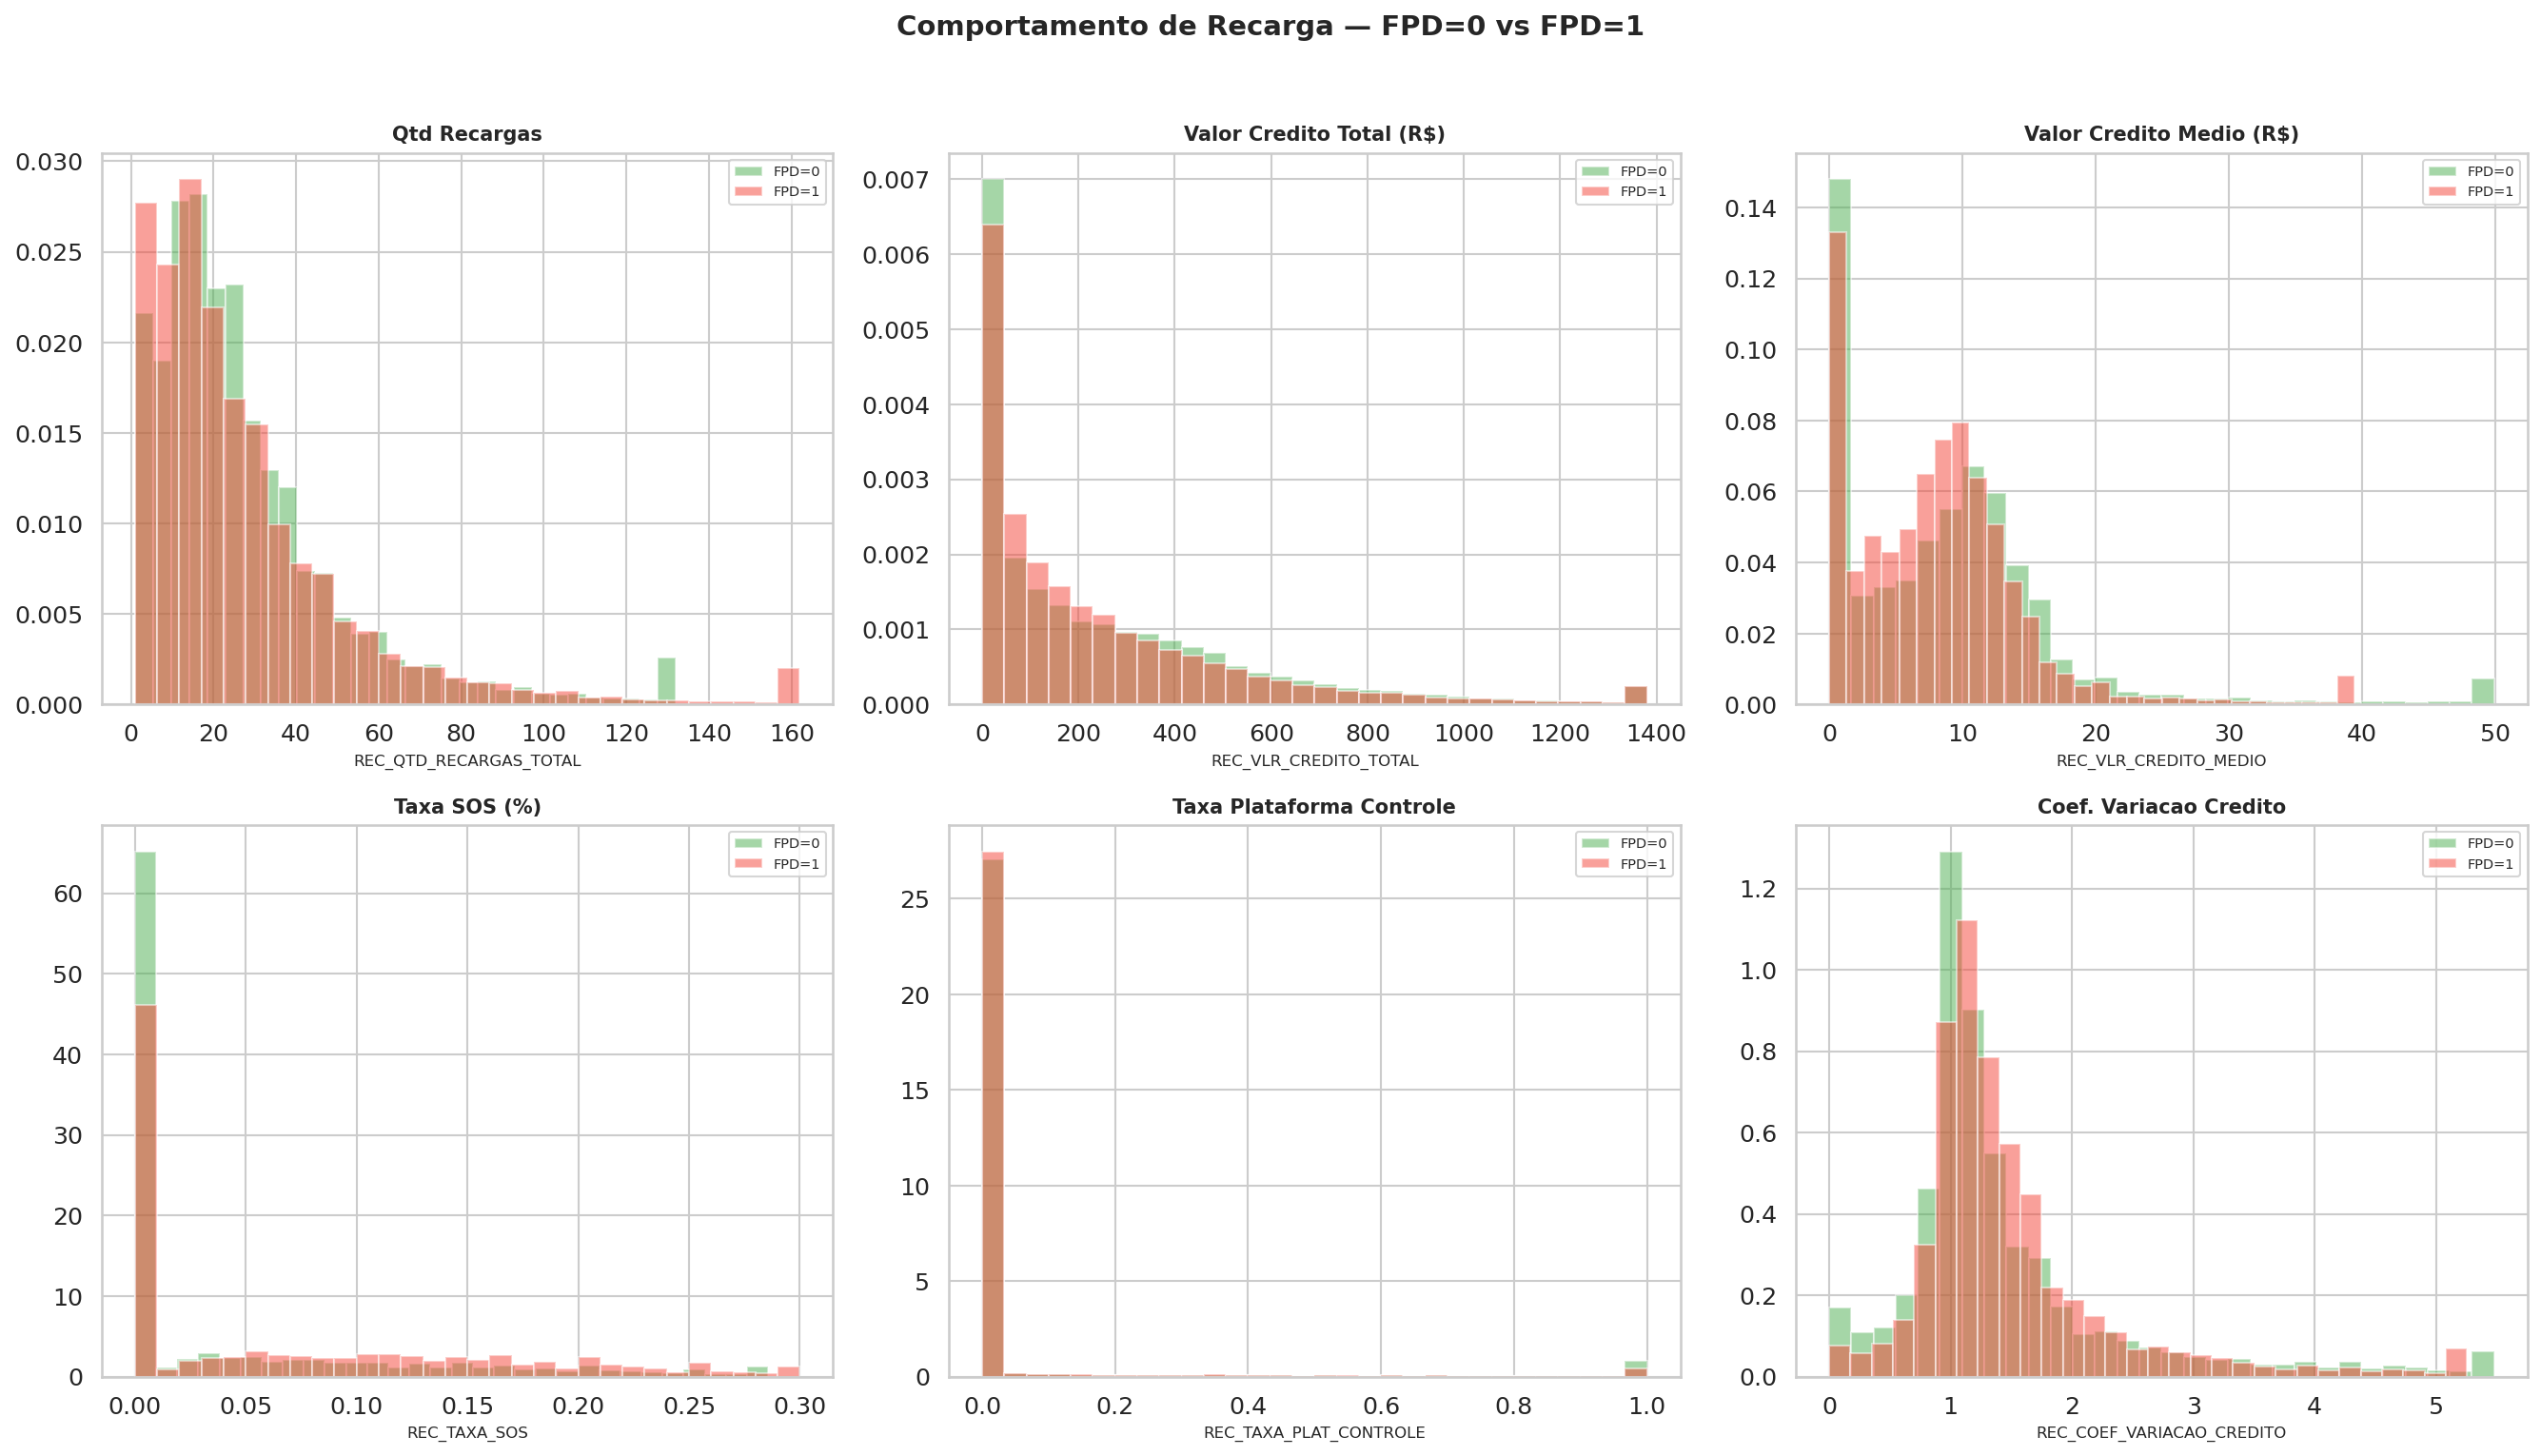


=== Media por FPD — Features de Recarga ===
 FPD  QTD_RECARGAS_TOTAL VLR_CREDITO_TOTAL VLR_CREDITO_MEDIO  TAXA_SOS  TAXA_PLAT_CONTROLE  COEF_VARIACAO_CREDITO
   0           29.145813      259.89100327    9.047862474617  0.043954            0.054895               1.468394
   1           29.431426      242.88121843    8.255497074597  0.071377            0.039460               1.513648


In [7]:
# ==============================================================================
# FIG 04 — Comportamento de Recarga vs FPD
# ==============================================================================

rec_features = [
    ("REC_QTD_RECARGAS_TOTAL", "Qtd Recargas"),
    ("REC_VLR_CREDITO_TOTAL", "Valor Credito Total (R$)"),
    ("REC_VLR_CREDITO_MEDIO", "Valor Credito Medio (R$)"),
    ("REC_TAXA_SOS", "Taxa SOS (%)"),
    ("REC_TAXA_PLAT_CONTROLE", "Taxa Plataforma Controle"),
    ("REC_COEF_VARIACAO_CREDITO", "Coef. Variacao Credito"),
]

# Filtrar features que existem no dataframe
rec_available = [(col, label) for col, label in rec_features if col in df.columns]

if rec_available:
    n = len(rec_available)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    # Amostrar dados para performance
    sample_cols = ["FPD"] + [c for c, _ in rec_available]
    df_rec = df.select(sample_cols).filter(F.col("FPD").isNotNull()).sample(False, 0.1, seed=42).toPandas()

    # Converter Decimal para float (Delta Lake retorna decimal.Decimal)
    for c in sample_cols:
        if c != "FPD":
            df_rec[c] = pd.to_numeric(df_rec[c], errors="coerce")

    for i, (col, label) in enumerate(rec_available):
        for fpd_val, fpd_color, fpd_label in [(0, "#4CAF50", "FPD=0"), (1, "#F44336", "FPD=1")]:
            data = df_rec.loc[df_rec["FPD"] == fpd_val, col].dropna()
            if len(data) > 0:
                # Clipar outliers para melhor visualizacao
                q99 = data.quantile(0.99)
                data_clipped = data.clip(upper=q99)
                axes[i].hist(data_clipped, bins=30, alpha=0.5, color=fpd_color,
                             label=fpd_label, density=True)
        axes[i].set_title(label, fontweight="bold", fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
        axes[i].legend(fontsize=7)

    # Ocultar axes extras
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle("Comportamento de Recarga — FPD=0 vs FPD=1", fontweight="bold", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/fig04_recarga_vs_fpd.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Tabela comparativa
    print("\n=== Media por FPD — Features de Recarga ===")
    agg_exprs = [F.mean(c).alias(c.replace("REC_", "")) for c, _ in rec_available]
    stats = df.filter(F.col("FPD").isNotNull()).groupBy("FPD").agg(*agg_exprs).orderBy("FPD").toPandas()
    print(stats.to_string(index=False))
else:
    print("Nenhuma feature REC_ disponivel no dataset.")

## 5. Analise Comportamental de Pagamento

Variaveis-chave do book de pagamento (prefixo `PAG_`):
- **Volumetria**: QTD_PAGAMENTOS_TOTAL, QTD_CONTRATOS, QTD_FATURAS_DISTINTAS
- **Valores**: VLR_PAGAMENTO_FATURA_TOTAL, VLR_JUROS_MULTAS_TOTAL
- **Taxas**: TAXA_STATUS_R (recusados), TAXA_PAGAMENTOS_COM_JUROS
- **Formas**: TAXA_FORMA_CA (cartao), TAXA_FORMA_PB (PIX/boleto), TAXA_FORMA_DD (debito direto)

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 9, Finished, Available, Finished)

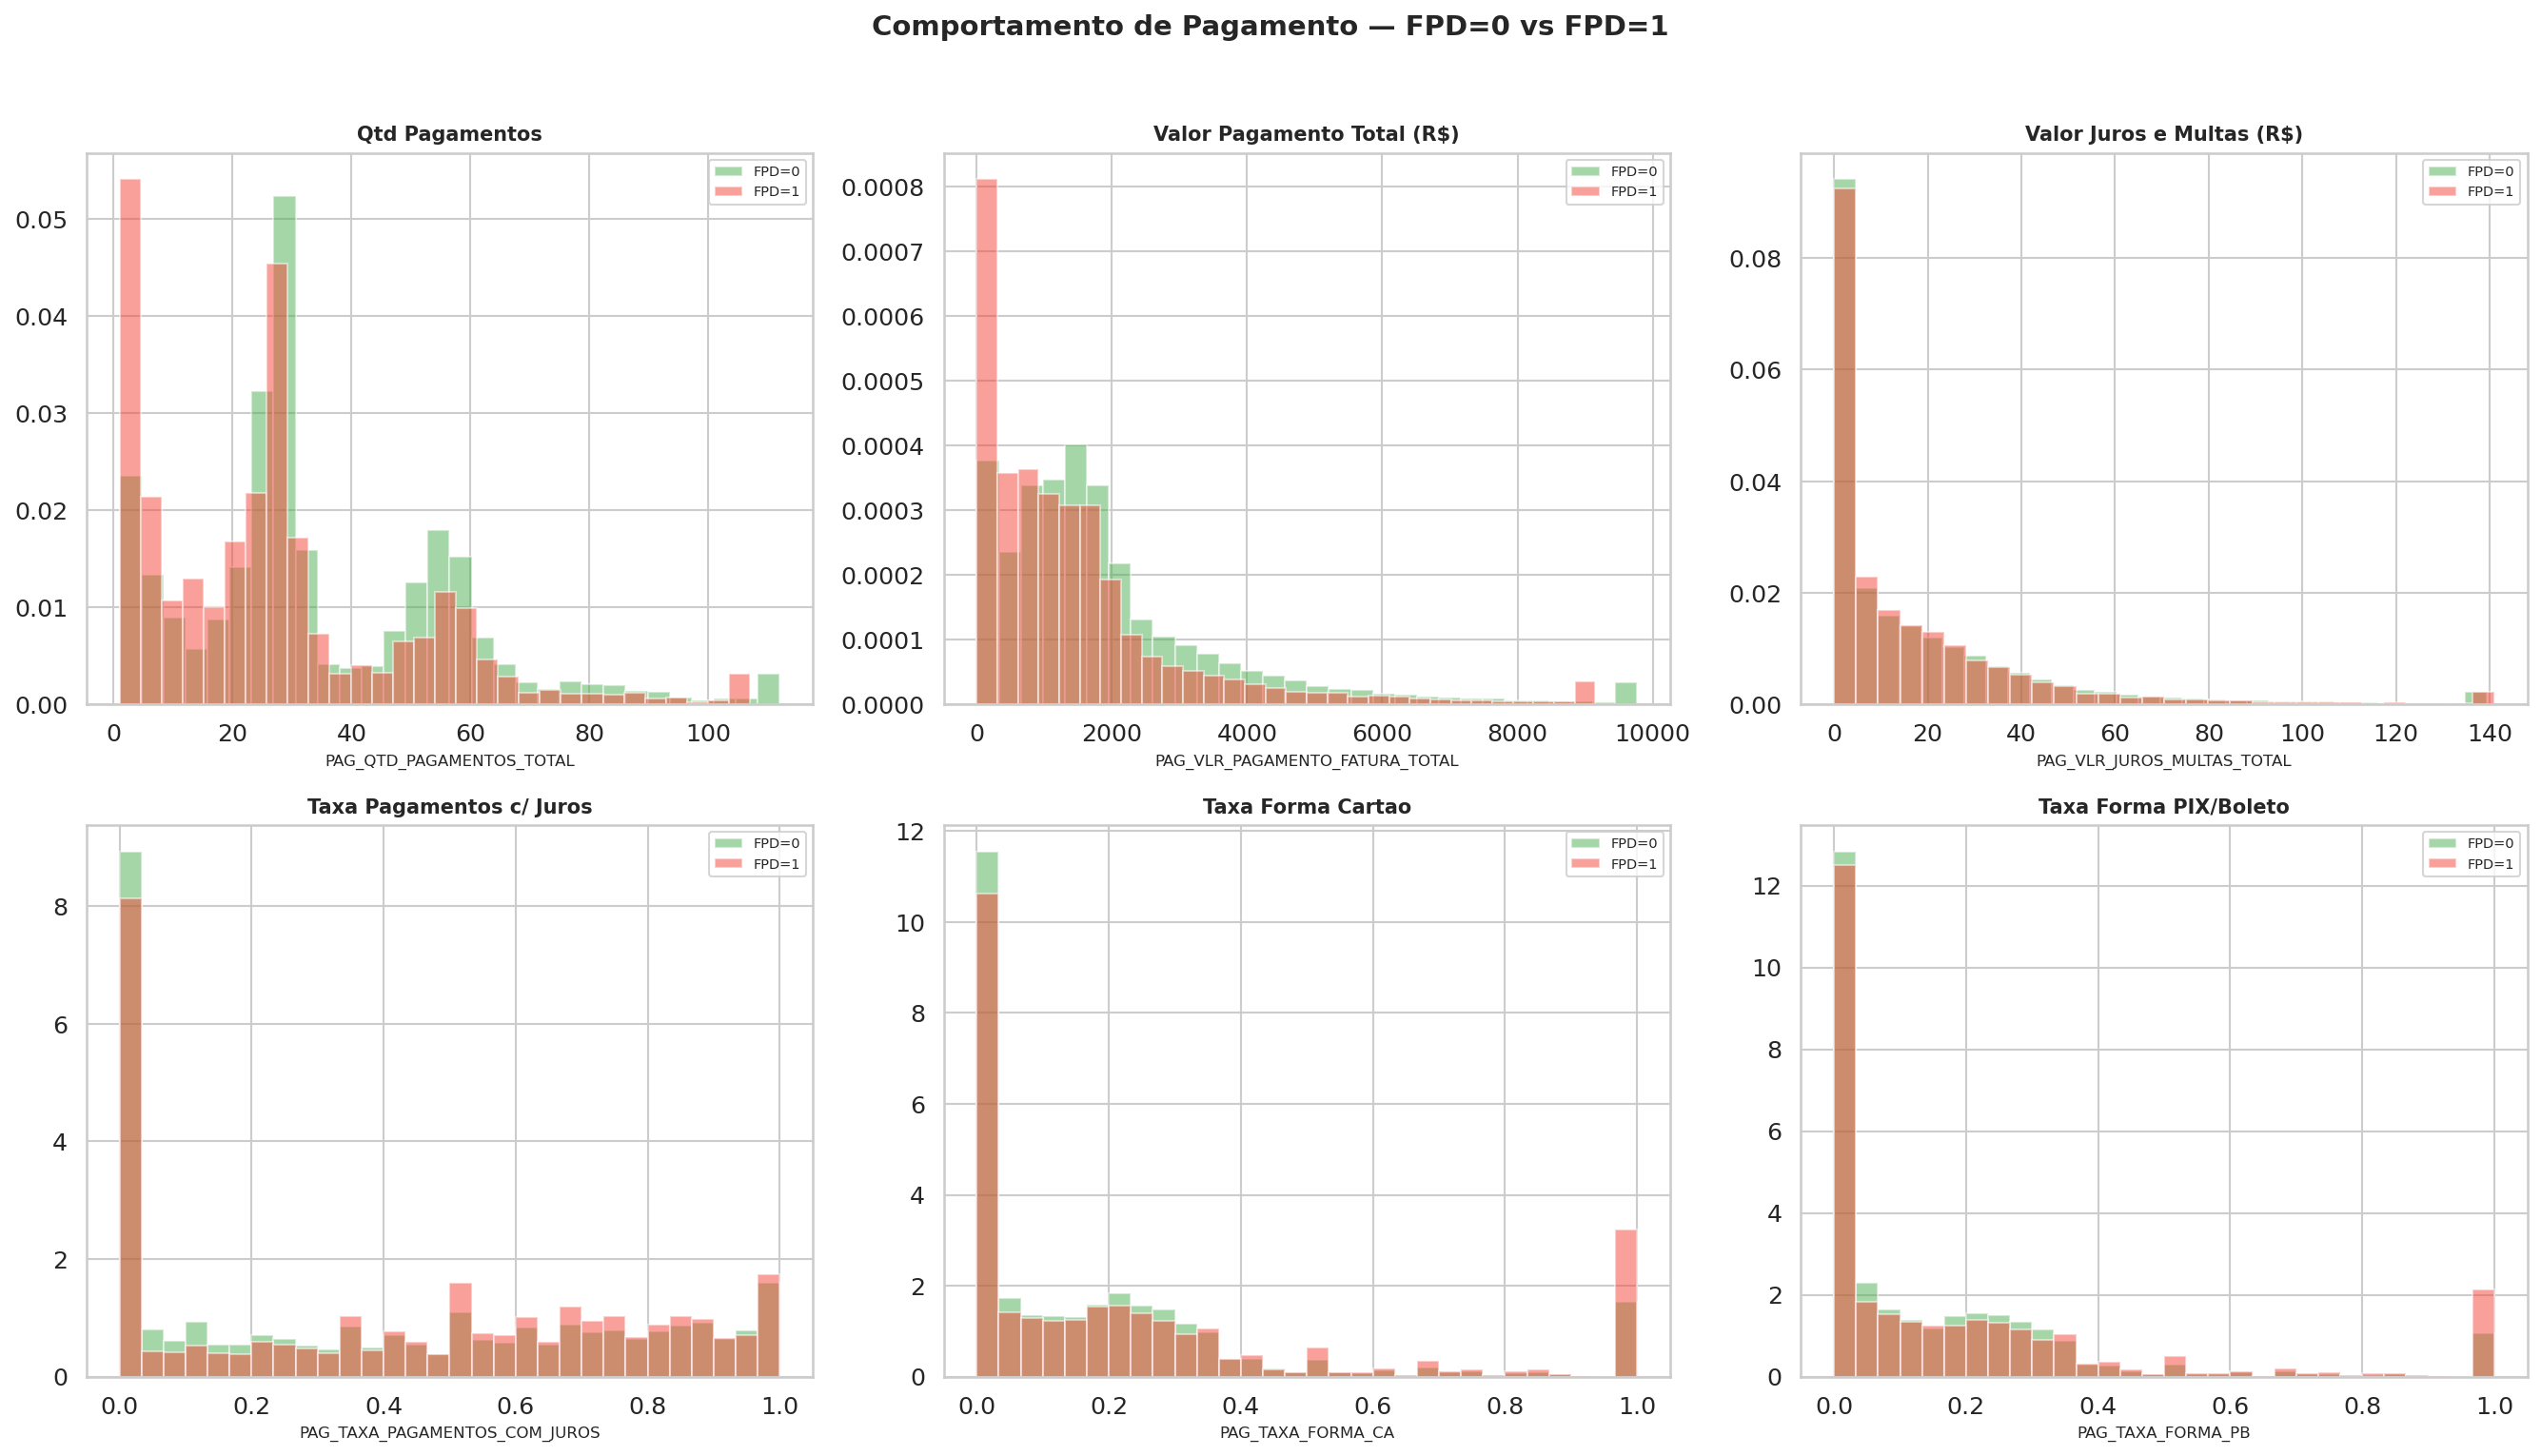


=== Media por FPD — Features de Pagamento ===
 FPD  QTD_PAGAMENTOS_TOTAL VLR_PAGAMENTO_FATURA_TOTAL VLR_JUROS_MULTAS_TOTAL  TAXA_PAGAMENTOS_COM_JUROS  TAXA_FORMA_CA  TAXA_FORMA_PB
   0             34.715742              2127.96741743            20.35179671                   0.385742       0.190142       0.153882
   1             27.102544              1631.69734266            19.88939629                   0.429268       0.251550       0.190258


In [8]:
# ==============================================================================
# FIG 05 — Comportamento de Pagamento vs FPD
# ==============================================================================

pag_features = [
    ("PAG_QTD_PAGAMENTOS_TOTAL", "Qtd Pagamentos"),
    ("PAG_VLR_PAGAMENTO_FATURA_TOTAL", "Valor Pagamento Total (R$)"),
    ("PAG_VLR_JUROS_MULTAS_TOTAL", "Valor Juros e Multas (R$)"),
    ("PAG_TAXA_PAGAMENTOS_COM_JUROS", "Taxa Pagamentos c/ Juros"),
    ("PAG_TAXA_FORMA_CA", "Taxa Forma Cartao"),
    ("PAG_TAXA_FORMA_PB", "Taxa Forma PIX/Boleto"),
]

pag_available = [(col, label) for col, label in pag_features if col in df.columns]

if pag_available:
    n = len(pag_available)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    sample_cols = ["FPD"] + [c for c, _ in pag_available]
    df_pag = df.select(sample_cols).filter(F.col("FPD").isNotNull()).sample(False, 0.1, seed=42).toPandas()

    # Converter Decimal para float (Delta Lake retorna decimal.Decimal)
    for c in sample_cols:
        if c != "FPD":
            df_pag[c] = pd.to_numeric(df_pag[c], errors="coerce")

    for i, (col, label) in enumerate(pag_available):
        for fpd_val, fpd_color, fpd_label in [(0, "#4CAF50", "FPD=0"), (1, "#F44336", "FPD=1")]:
            data = df_pag.loc[df_pag["FPD"] == fpd_val, col].dropna()
            if len(data) > 0:
                q99 = data.quantile(0.99)
                data_clipped = data.clip(upper=q99)
                axes[i].hist(data_clipped, bins=30, alpha=0.5, color=fpd_color,
                             label=fpd_label, density=True)
        axes[i].set_title(label, fontweight="bold", fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
        axes[i].legend(fontsize=7)

    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle("Comportamento de Pagamento — FPD=0 vs FPD=1", fontweight="bold", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/fig05_pagamento_vs_fpd.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\n=== Media por FPD — Features de Pagamento ===")
    agg_exprs = [F.mean(c).alias(c.replace("PAG_", "")) for c, _ in pag_available]
    stats = df.filter(F.col("FPD").isNotNull()).groupBy("FPD").agg(*agg_exprs).orderBy("FPD").toPandas()
    print(stats.to_string(index=False))
else:
    print("Nenhuma feature PAG_ disponivel no dataset.")

## 6. Analise Comportamental de Faturamento

Variaveis-chave do book de faturamento (prefixo `FAT_`):
- **WO (Write-Off)**: QTD_FATURAS_WO, TAXA_WO — faturas irrecuperaveis
- **PDD (Provisao)**: QTD_FATURAS_PDD, TAXA_PDD — provisao de devedores duvidosos
- **Atraso**: DIAS_ATRASO_MEDIO, TAXA_ATRASO, TAXA_ATRASO_30D/60D/90D
- **Valores**: VLR_FAT_BRUTO_TOTAL, VLR_FAT_ABERTO_TOTAL
- **Inadimplencia**: QTD_FATURAS_ISENTAS, VLR_MULTA_JUROS_TOTAL

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 10, Finished, Available, Finished)

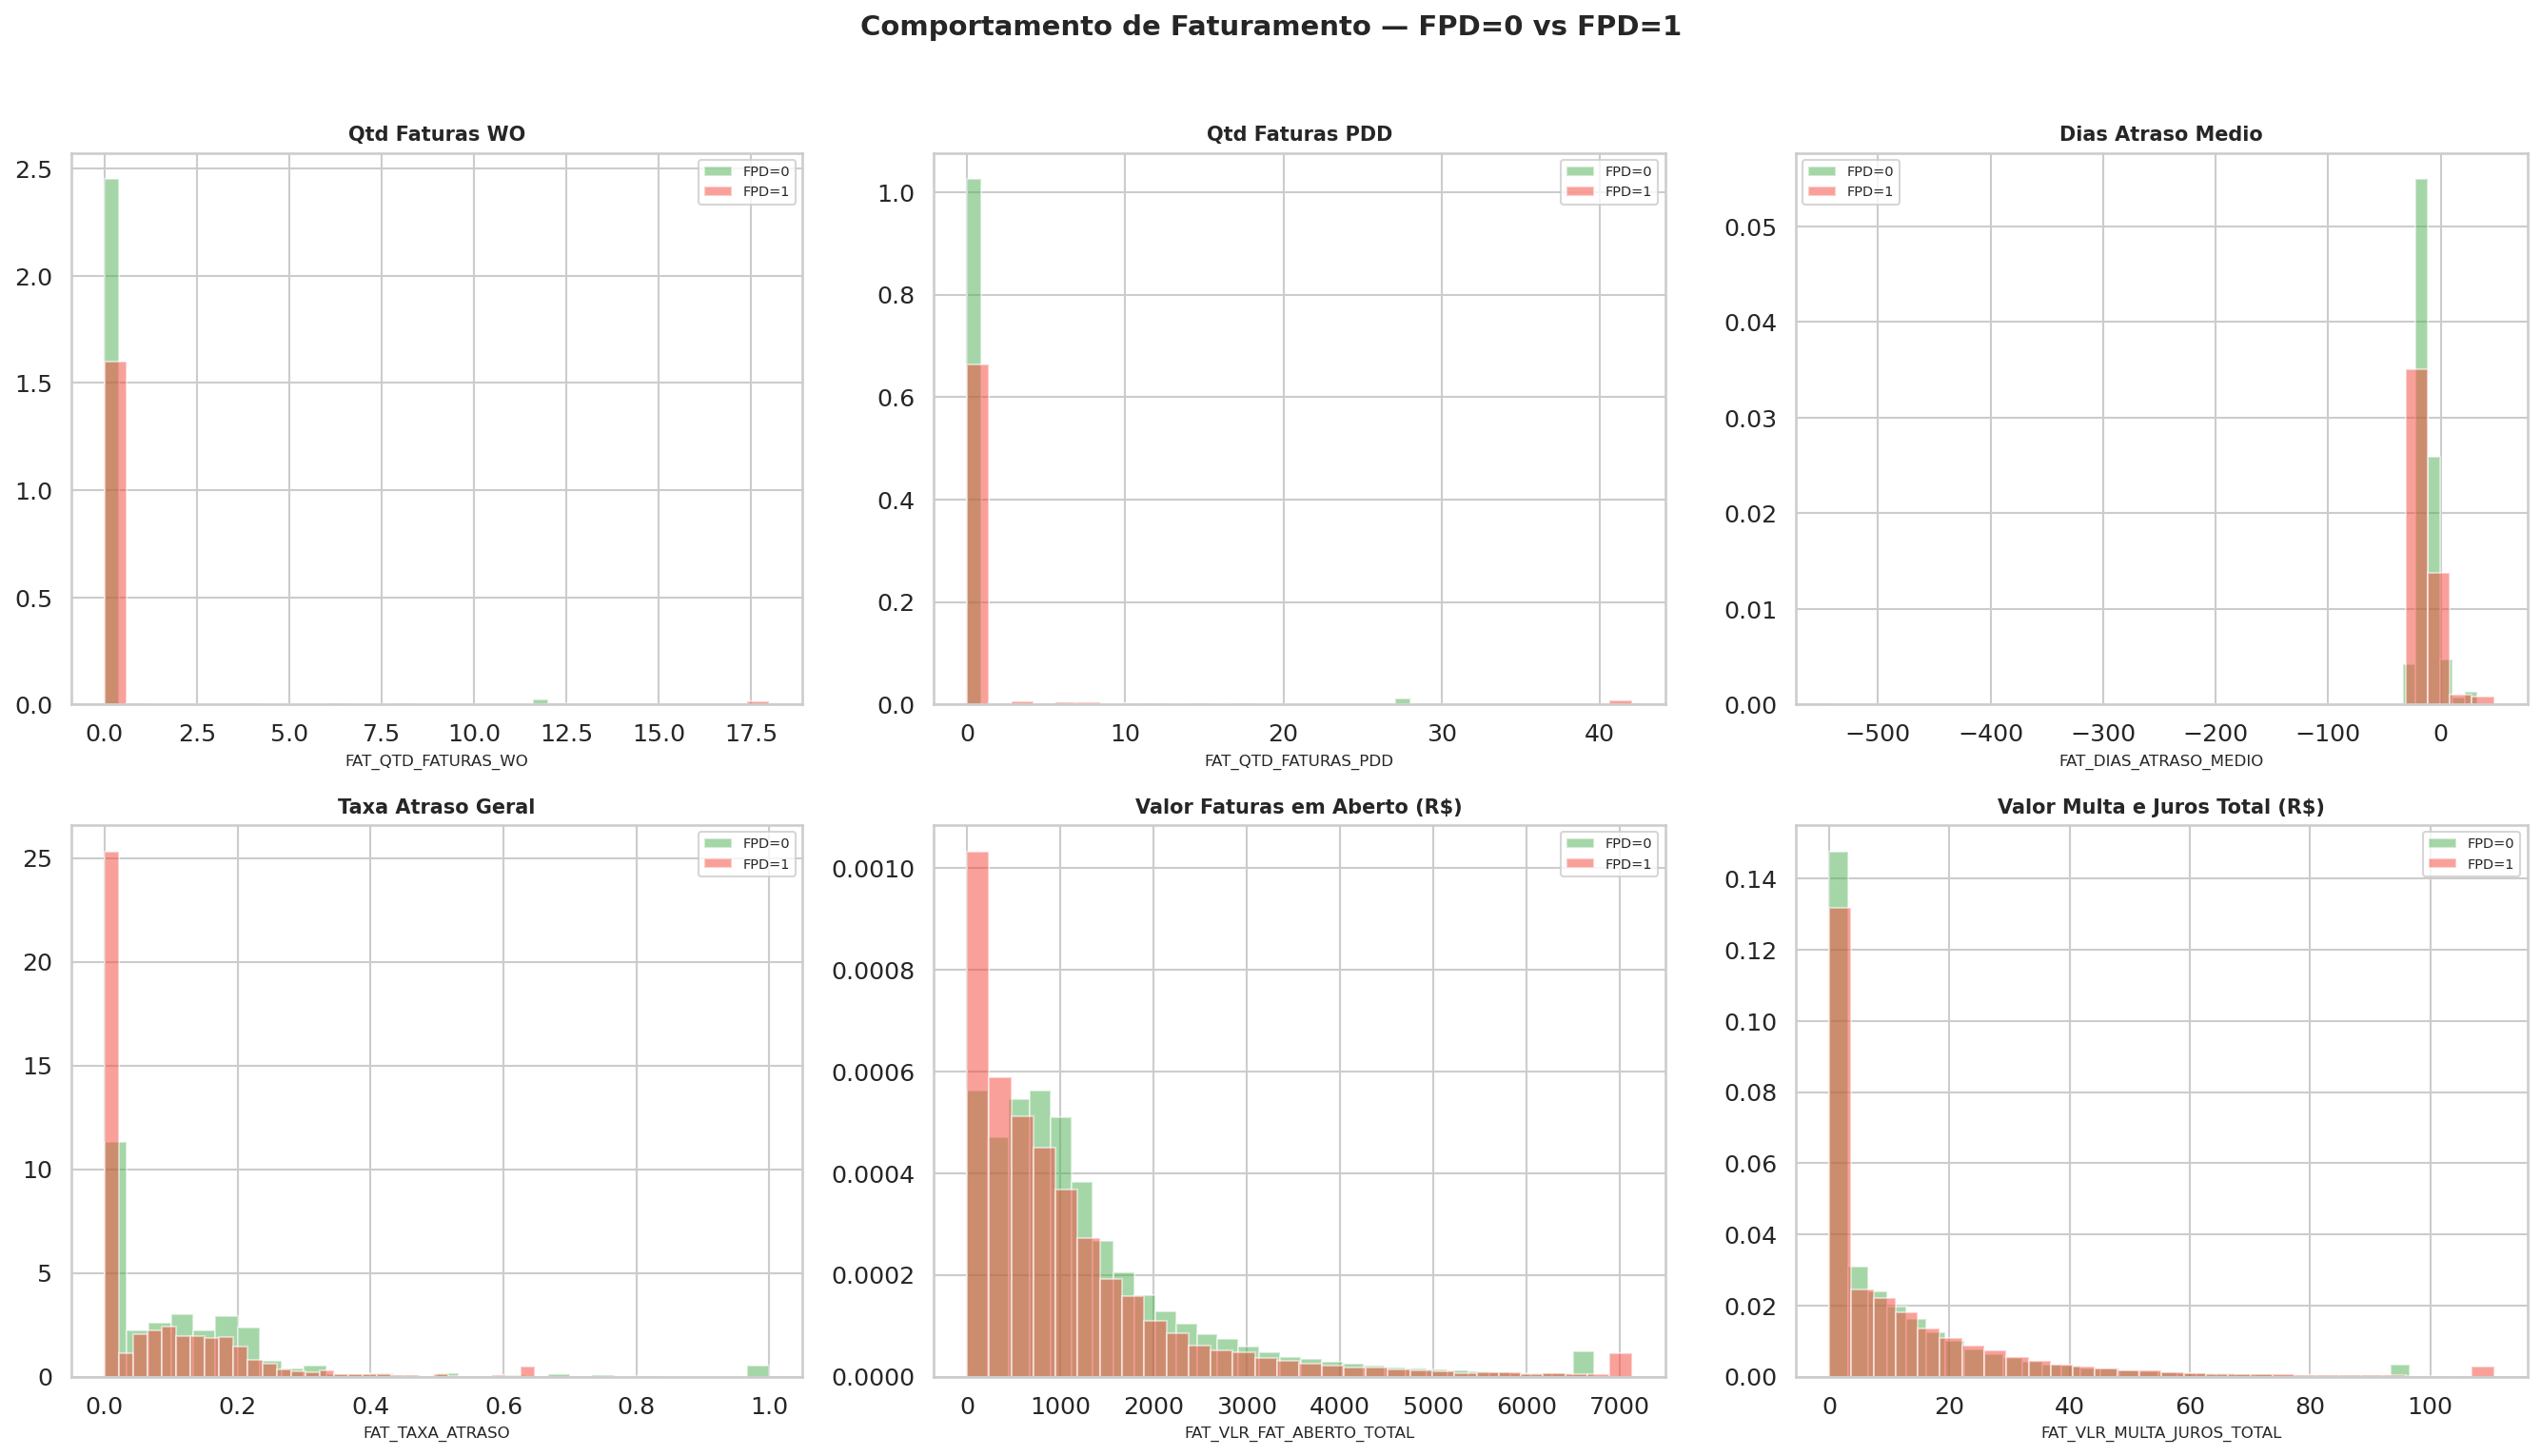


=== Media por FPD — Features de Faturamento ===
 FPD  QTD_FATURAS_WO  QTD_FATURAS_PDD  DIAS_ATRASO_MEDIO  TAXA_ATRASO VLR_ABERTO_TOTAL VLR_MULTA_JUROS_TOTAL
   0        0.501183         1.061913         -11.348590     0.120653    1638.80226503           19.53263717
   1        0.700626         1.609254         -11.709795     0.077479    1338.09682352           18.01504778


In [9]:
# ==============================================================================
# FIG 06 — Comportamento de Faturamento vs FPD
# ==============================================================================

fat_features = [
    ("FAT_QTD_FATURAS_WO", "Qtd Faturas WO"),
    ("FAT_QTD_FATURAS_PDD", "Qtd Faturas PDD"),
    ("FAT_DIAS_ATRASO_MEDIO", "Dias Atraso Medio"),
    ("FAT_TAXA_ATRASO", "Taxa Atraso Geral"),
    ("FAT_VLR_FAT_ABERTO_TOTAL", "Valor Faturas em Aberto (R$)"),
    ("FAT_VLR_MULTA_JUROS_TOTAL", "Valor Multa e Juros Total (R$)"),
]

fat_available = [(col, label) for col, label in fat_features if col in df.columns]

if fat_available:
    n = len(fat_available)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    sample_cols = ["FPD"] + [c for c, _ in fat_available]
    df_fat = df.select(sample_cols).filter(F.col("FPD").isNotNull()).sample(False, 0.1, seed=42).toPandas()

    # Converter Decimal para float (Delta Lake retorna decimal.Decimal)
    for c in sample_cols:
        if c != "FPD":
            df_fat[c] = pd.to_numeric(df_fat[c], errors="coerce")

    for i, (col, label) in enumerate(fat_available):
        for fpd_val, fpd_color, fpd_label in [(0, "#4CAF50", "FPD=0"), (1, "#F44336", "FPD=1")]:
            data = df_fat.loc[df_fat["FPD"] == fpd_val, col].dropna()
            if len(data) > 0:
                q99 = data.quantile(0.99)
                data_clipped = data.clip(upper=q99)
                axes[i].hist(data_clipped, bins=30, alpha=0.5, color=fpd_color,
                             label=fpd_label, density=True)
        axes[i].set_title(label, fontweight="bold", fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
        axes[i].legend(fontsize=7)

    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle("Comportamento de Faturamento — FPD=0 vs FPD=1", fontweight="bold", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/fig06_faturamento_vs_fpd.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\n=== Media por FPD — Features de Faturamento ===")
    agg_exprs = [F.mean(c).alias(c.replace("FAT_", "")) for c, _ in fat_available]
    stats = df.filter(F.col("FPD").isNotNull()).groupBy("FPD").agg(*agg_exprs).orderBy("FPD").toPandas()
    print(stats.to_string(index=False))
else:
    print("Nenhuma feature FAT_ disponivel no dataset.")

## 7. Perfil de Migracao PRE -> CONTROLE

A coluna `flag_mig2` indica o tipo de migracao do cliente:
- **Aquisicao**: Cliente novo direto no controle
- **PRE**: Migrou de pre-pago para controle
- **FLEX**: Migrou de flex para controle
- **None/null**: Sem informacao de migracao

Tambem analisamos a plataforma de recarga (`REC_TAXA_PLAT_CONTROLE`) como proxy de migracao efetiva.

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 11, Finished, Available, Finished)

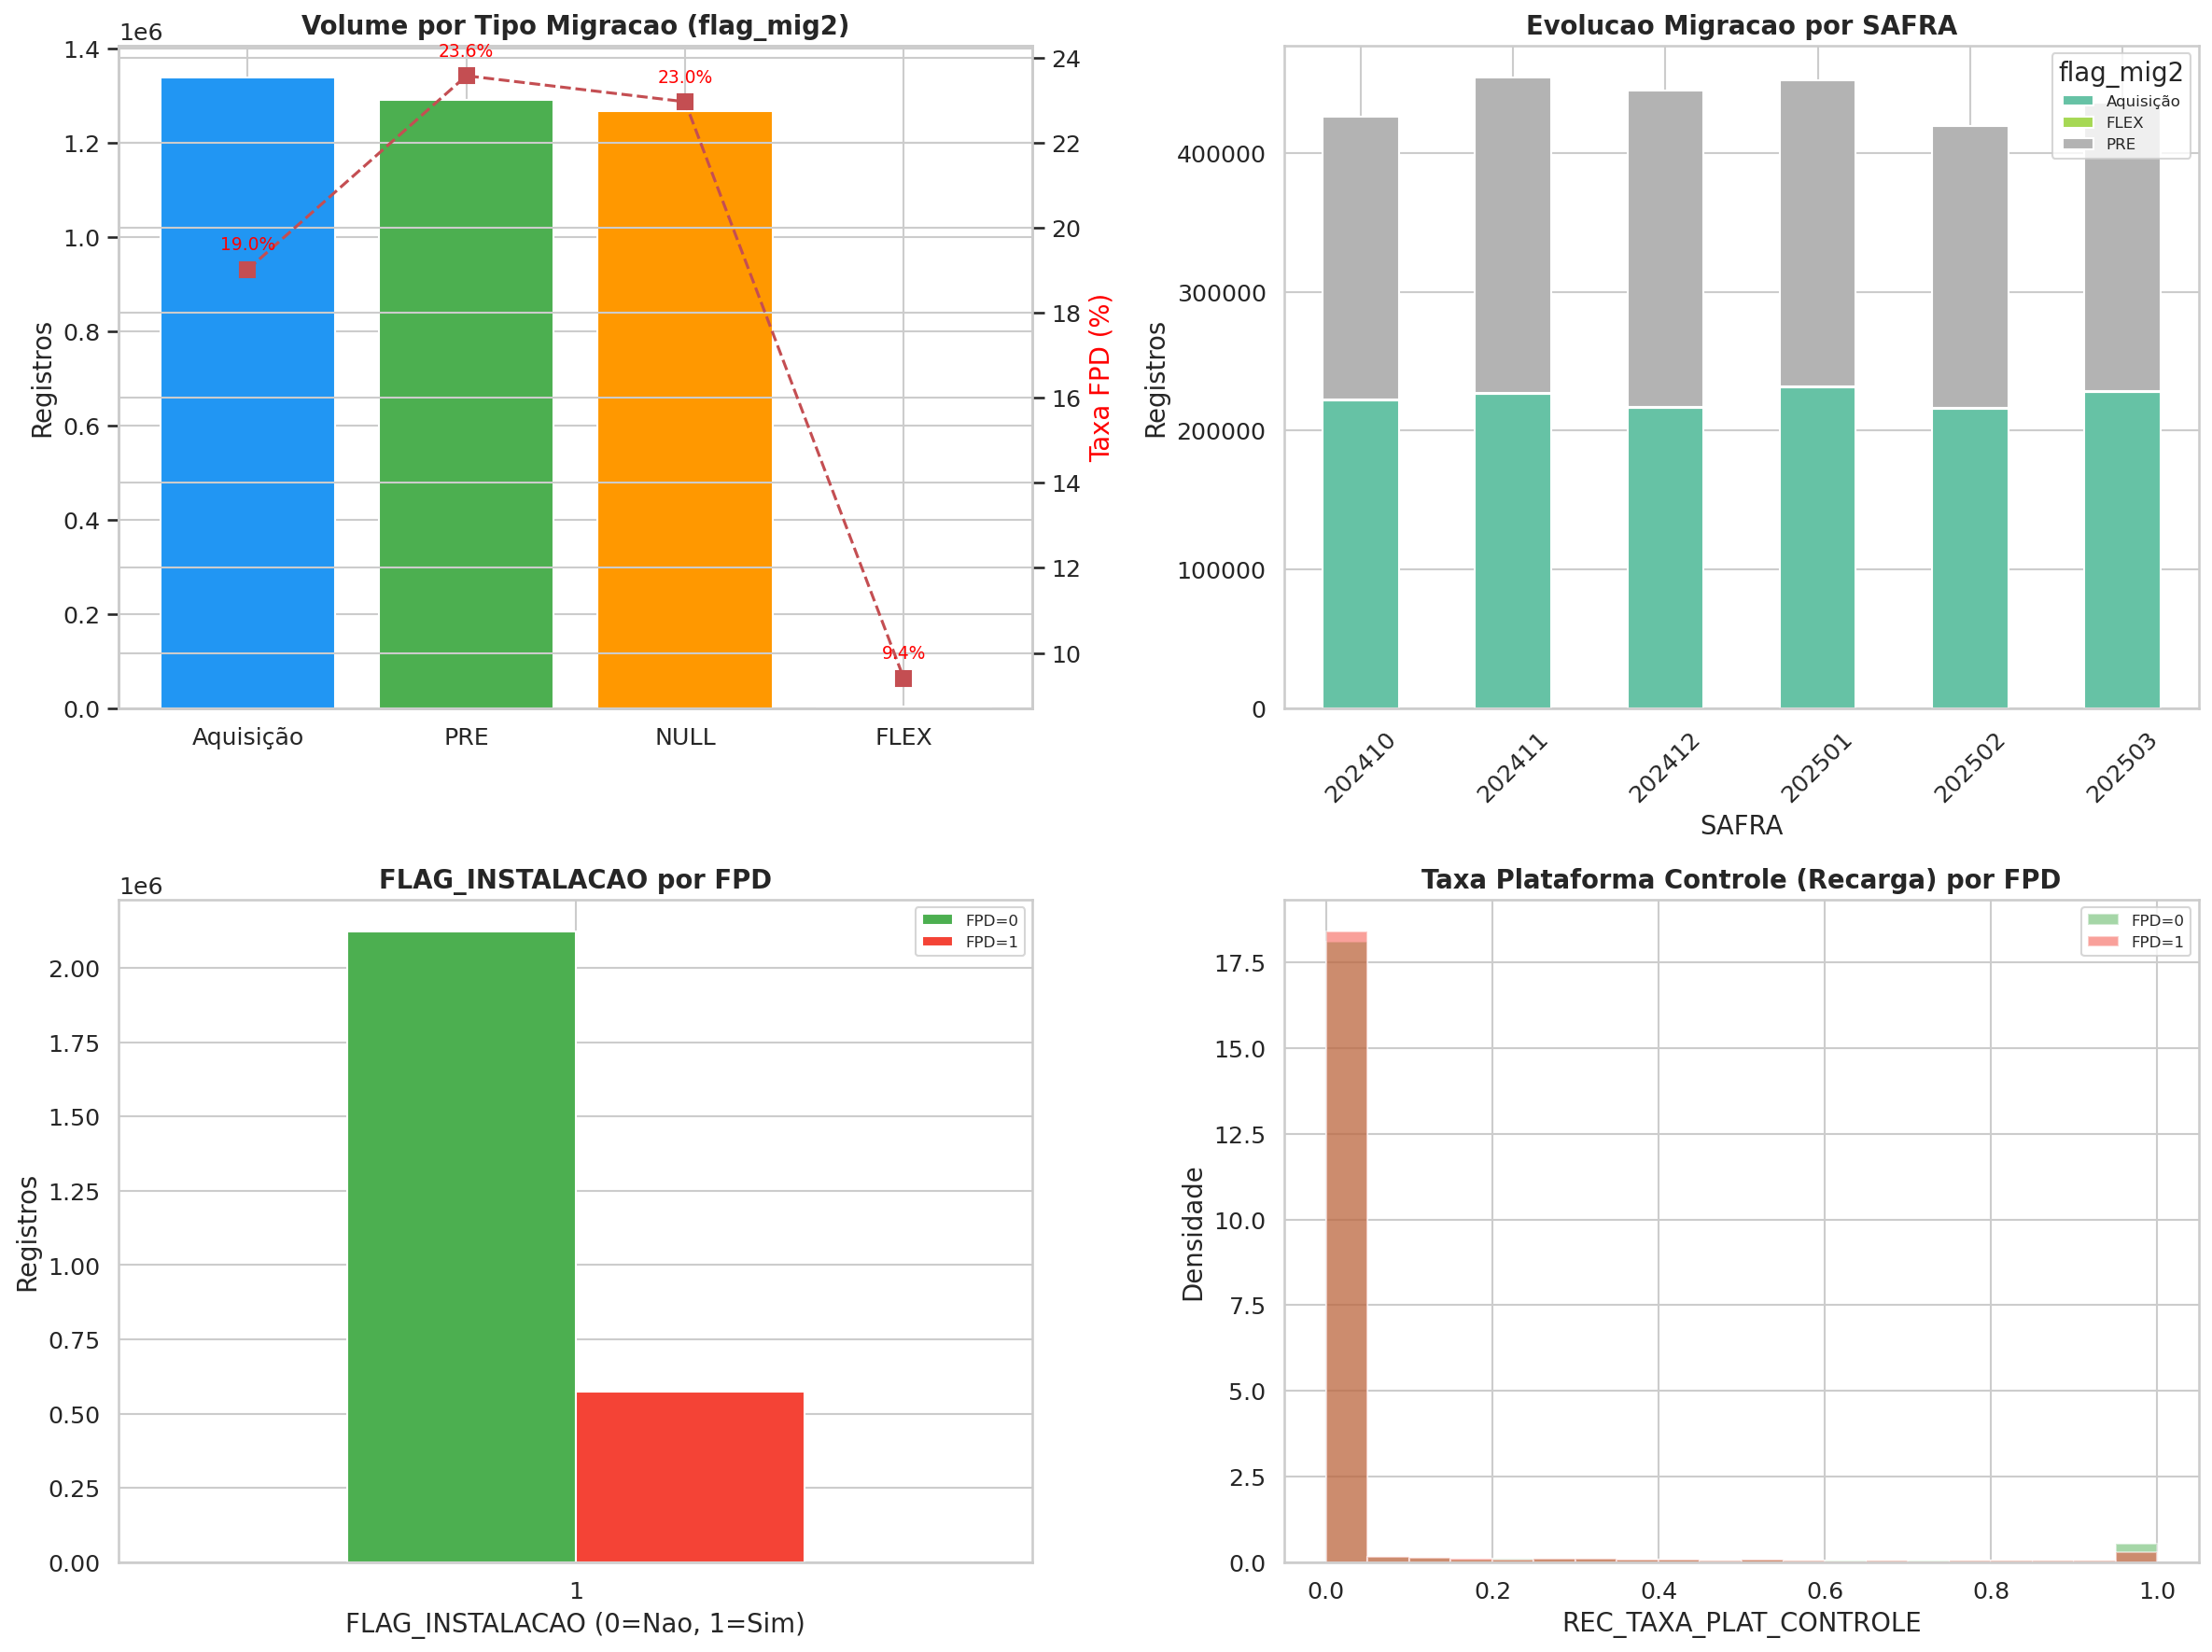

In [10]:
# ==============================================================================
# FIG 07 — Perfil de Migracao PRE -> CONTROLE
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 7a: Distribuicao flag_mig2 ---
try:
    mig_dist = df.groupBy("flag_mig2").agg(
        F.count("*").alias("total"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy(F.desc("total")).toPandas()
    mig_dist["flag_mig2"] = mig_dist["flag_mig2"].fillna("NULL")

    colors_mig = ["#2196F3", "#4CAF50", "#FF9800", "#9E9E9E", "#9C27B0"][:len(mig_dist)]
    bars = axes[0,0].bar(mig_dist["flag_mig2"], mig_dist["total"], color=colors_mig)
    axes[0,0].set_title("Volume por Tipo Migracao (flag_mig2)", fontweight="bold")
    axes[0,0].set_ylabel("Registros")
    ax2 = axes[0,0].twinx()
    ax2.plot(mig_dist["flag_mig2"], mig_dist["taxa_fpd"]*100, 'rs--', markersize=8)
    ax2.set_ylabel("Taxa FPD (%)", color="red")
    for i_m, row in mig_dist.iterrows():
        if pd.notna(row["taxa_fpd"]):
            ax2.annotate(f"{row['taxa_fpd']*100:.1f}%",
                         (row['flag_mig2'], row['taxa_fpd']*100),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color="red")
except Exception as e:
    axes[0,0].text(0.5, 0.5, f"flag_mig2 indisponivel\n{e}", transform=axes[0,0].transAxes, ha="center")

# --- 7b: flag_mig2 por SAFRA (evolucao temporal) ---
try:
    mig_safra = df.filter(F.col("flag_mig2").isNotNull()).groupBy("SAFRA", "flag_mig2").agg(
        F.count("*").alias("total")
    ).orderBy("SAFRA").toPandas()

    pivot_mig = mig_safra.pivot(index="SAFRA", columns="flag_mig2", values="total").fillna(0)
    pivot_mig.plot(kind="bar", stacked=True, ax=axes[0,1], colormap="Set2", edgecolor="white")
    axes[0,1].set_title("Evolucao Migracao por SAFRA", fontweight="bold")
    axes[0,1].set_ylabel("Registros")
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(title="flag_mig2", fontsize=8)
except Exception as e:
    axes[0,1].text(0.5, 0.5, f"Erro\n{e}", transform=axes[0,1].transAxes, ha="center")

# --- 7c: FLAG_INSTALACAO por FPD ---
try:
    inst_dist = df.filter(F.col("FPD").isNotNull()).groupBy("FLAG_INSTALACAO", "FPD").agg(
        F.count("*").alias("total")
    ).orderBy("FLAG_INSTALACAO", "FPD").toPandas()

    pivot_inst = inst_dist.pivot(index="FLAG_INSTALACAO", columns="FPD", values="total").fillna(0)
    pivot_inst.plot(kind="bar", ax=axes[1,0], color=["#4CAF50", "#F44336"], edgecolor="white")
    axes[1,0].set_title("FLAG_INSTALACAO por FPD", fontweight="bold")
    axes[1,0].set_xlabel("FLAG_INSTALACAO (0=Nao, 1=Sim)")
    axes[1,0].set_ylabel("Registros")
    axes[1,0].legend(["FPD=0", "FPD=1"], fontsize=8)
    axes[1,0].tick_params(axis='x', rotation=0)
except Exception as e:
    axes[1,0].text(0.5, 0.5, f"Erro\n{e}", transform=axes[1,0].transAxes, ha="center")

# --- 7d: REC_TAXA_PLAT_CONTROLE por FPD (proxy migracao efetiva) ---
try:
    if "REC_TAXA_PLAT_CONTROLE" in df.columns:
        df_plat = df.select("FPD", "REC_TAXA_PLAT_CONTROLE").filter(
            F.col("FPD").isNotNull() & F.col("REC_TAXA_PLAT_CONTROLE").isNotNull()
        ).sample(False, 0.1, seed=42).toPandas()

        # Converter Decimal para float (Delta Lake retorna decimal.Decimal)
        df_plat["REC_TAXA_PLAT_CONTROLE"] = pd.to_numeric(df_plat["REC_TAXA_PLAT_CONTROLE"], errors="coerce")

        for fpd_val, color, label in [(0, "#4CAF50", "FPD=0"), (1, "#F44336", "FPD=1")]:
            data = df_plat.loc[df_plat["FPD"] == fpd_val, "REC_TAXA_PLAT_CONTROLE"].dropna()
            axes[1,1].hist(data, bins=20, alpha=0.5, color=color, label=label, density=True)
        axes[1,1].set_title("Taxa Plataforma Controle (Recarga) por FPD", fontweight="bold")
        axes[1,1].set_xlabel("REC_TAXA_PLAT_CONTROLE")
        axes[1,1].set_ylabel("Densidade")
        axes[1,1].legend(fontsize=8)
    else:
        axes[1,1].text(0.5, 0.5, "REC_TAXA_PLAT_CONTROLE\nnao disponivel",
                       transform=axes[1,1].transAxes, ha="center")
except Exception as e:
    axes[1,1].text(0.5, 0.5, f"Erro\n{e}", transform=axes[1,1].transAxes, ha="center")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/fig07_migracao_pre_controle.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Correlacao de Features com Target

Calculo da **correlacao de Pearson** entre cada feature numerica e o target FPD, identificando as 20 features com maior poder preditivo (maior valor absoluto de correlacao).

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 12, Finished, Available, Finished)

Total features numericas para correlacao: 210
Correlacoes calculadas: 198


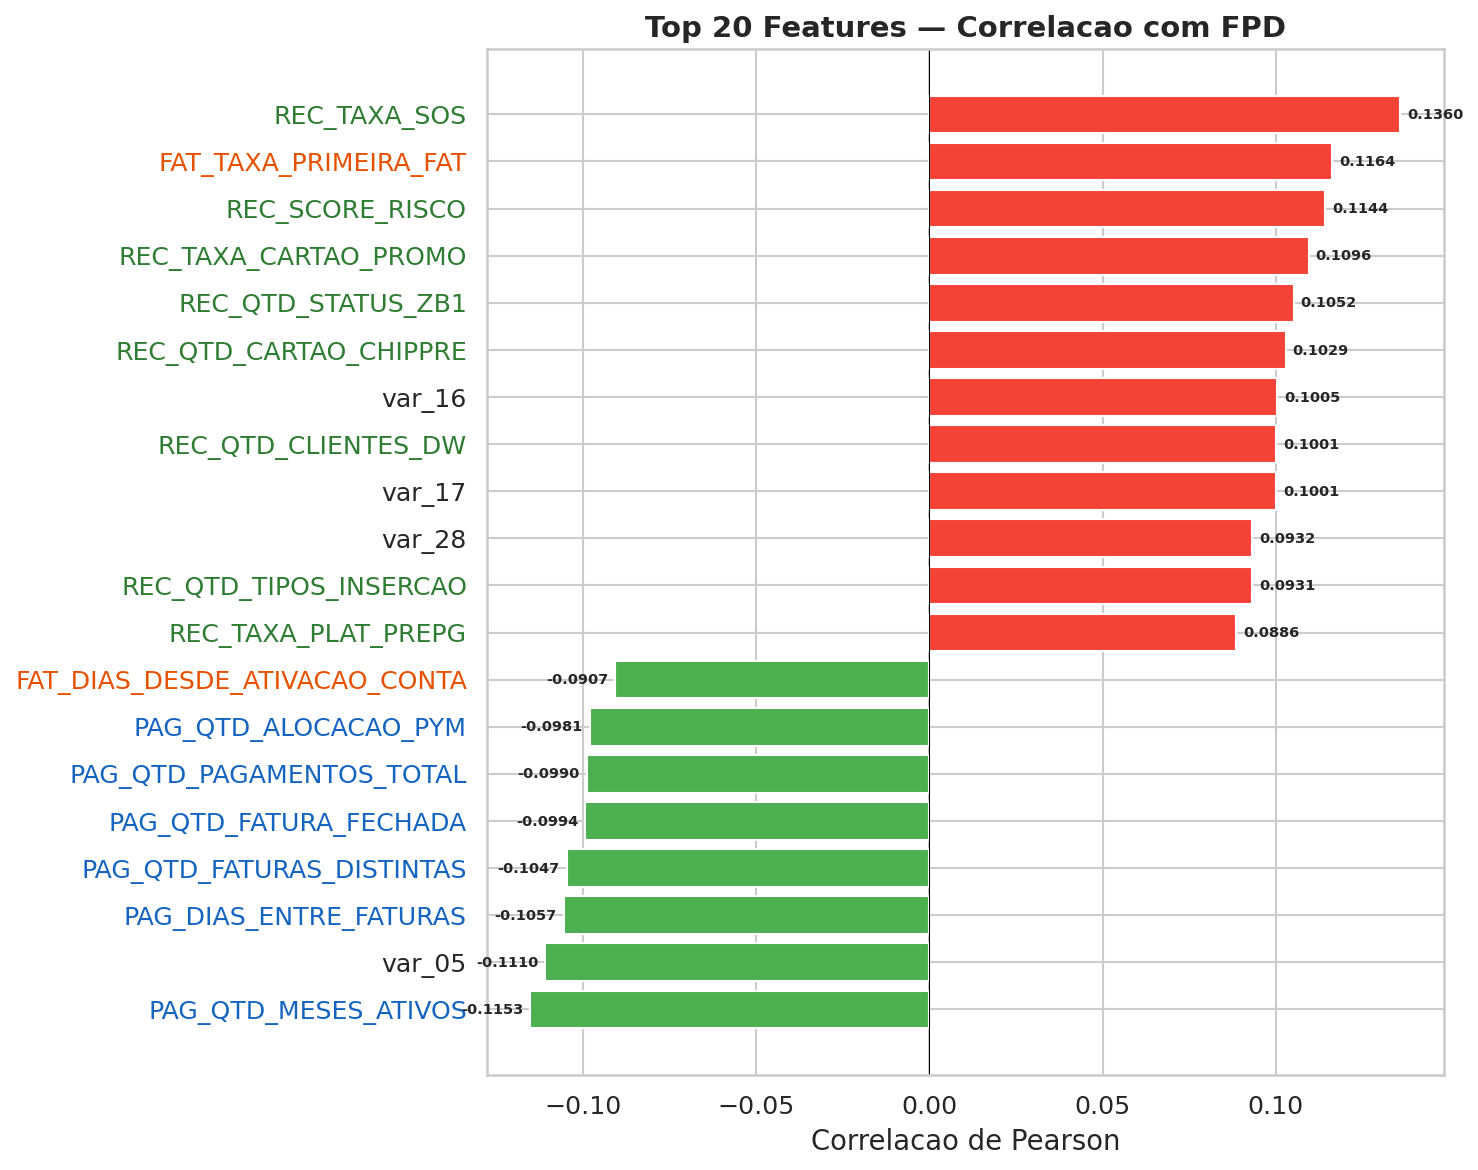


=== Top 20 Features Correlacionadas com FPD ===
                      feature  correlacao  abs_corr
         PAG_QTD_MESES_ATIVOS   -0.115295  0.115295
                       var_05   -0.111042  0.111042
       PAG_DIAS_ENTRE_FATURAS   -0.105668  0.105668
    PAG_QTD_FATURAS_DISTINTAS   -0.104726  0.104726
       PAG_QTD_FATURA_FECHADA   -0.099447  0.099447
     PAG_QTD_PAGAMENTOS_TOTAL   -0.098954  0.098954
         PAG_QTD_ALOCACAO_PYM   -0.098136  0.098136
FAT_DIAS_DESDE_ATIVACAO_CONTA   -0.090705  0.090705
          REC_TAXA_PLAT_PREPG    0.088623  0.088623
       REC_QTD_TIPOS_INSERCAO    0.093122  0.093122
                       var_28    0.093235  0.093235
                       var_17    0.100058  0.100058
          REC_QTD_CLIENTES_DW    0.100077  0.100077
                       var_16    0.100480  0.100480
       REC_QTD_CARTAO_CHIPPRE    0.102889  0.102889
           REC_QTD_STATUS_ZB1    0.105242  0.105242
        REC_TAXA_CARTAO_PROMO    0.109557  0.109557
              R

In [11]:
# ==============================================================================
# FIG 08 — Top 20 Features mais correlacionadas com FPD
# ==============================================================================

# Identificar colunas numericas (excluir metadata, PKs e targets)
exclude_cols = {"NUM_CPF", "SAFRA", "FPD", "TARGET_SCORE_01", "TARGET_SCORE_02",
                "_execution_id", "_data_inclusao", "_data_alteracao_silver", "DT_PROCESSAMENTO"}

numeric_cols = []
for field in df.schema.fields:
    if field.name not in exclude_cols and isinstance(field.dataType, (DoubleType, IntegerType)):
        numeric_cols.append(field.name)

# Tambem incluir LongType
from pyspark.sql.types import LongType, FloatType
for field in df.schema.fields:
    if field.name not in exclude_cols and isinstance(field.dataType, (LongType, FloatType)):
        if field.name not in numeric_cols:
            numeric_cols.append(field.name)

print(f"Total features numericas para correlacao: {len(numeric_cols)}")

# Calcular correlacao com FPD (batch para performance)
df_fpd = df.filter(F.col("FPD").isNotNull())

# Processar em batches de 50 colunas
correlations = {}
batch_size = 50
for i in range(0, len(numeric_cols), batch_size):
    batch = numeric_cols[i:i+batch_size]
    for col_name in batch:
        try:
            corr_val = df_fpd.stat.corr(col_name, "FPD")
            if corr_val is not None and not np.isnan(corr_val):
                correlations[col_name] = corr_val
        except Exception:
            pass

print(f"Correlacoes calculadas: {len(correlations)}")

# Top 20 por valor absoluto
corr_df = pd.DataFrame(list(correlations.items()), columns=["feature", "correlacao"])
corr_df["abs_corr"] = corr_df["correlacao"].abs()
top20 = corr_df.nlargest(20, "abs_corr").sort_values("correlacao")

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["#F44336" if c > 0 else "#4CAF50" for c in top20["correlacao"]]
bars = ax.barh(top20["feature"], top20["correlacao"], color=colors, edgecolor="white")
ax.set_title("Top 20 Features — Correlacao com FPD", fontweight="bold", fontsize=14)
ax.set_xlabel("Correlacao de Pearson")
ax.axvline(x=0, color='black', linewidth=0.5)

# Annotate values
for bar, val in zip(bars, top20["correlacao"]):
    x_pos = val + 0.002 if val >= 0 else val - 0.002
    ha = "left" if val >= 0 else "right"
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            f"{val:.4f}", va="center", ha=ha, fontsize=7, fontweight="bold")

# Colorir por prefixo
for label in ax.get_yticklabels():
    text = label.get_text()
    if text.startswith("REC_"):
        label.set_color("#2E7D32")
    elif text.startswith("PAG_"):
        label.set_color("#1565C0")
    elif text.startswith("FAT_"):
        label.set_color("#E65100")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/fig08_top20_correlacao_fpd.png", dpi=150, bbox_inches="tight")
plt.show()

# Tabela completa top 20
print("\n=== Top 20 Features Correlacionadas com FPD ===")
print(top20[["feature", "correlacao", "abs_corr"]].to_string(index=False))

## 9. Insights e Conclusoes

Consolidacao dos achados com tabela resumo e recomendacoes para modelagem.

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 13, Finished, Available, Finished)

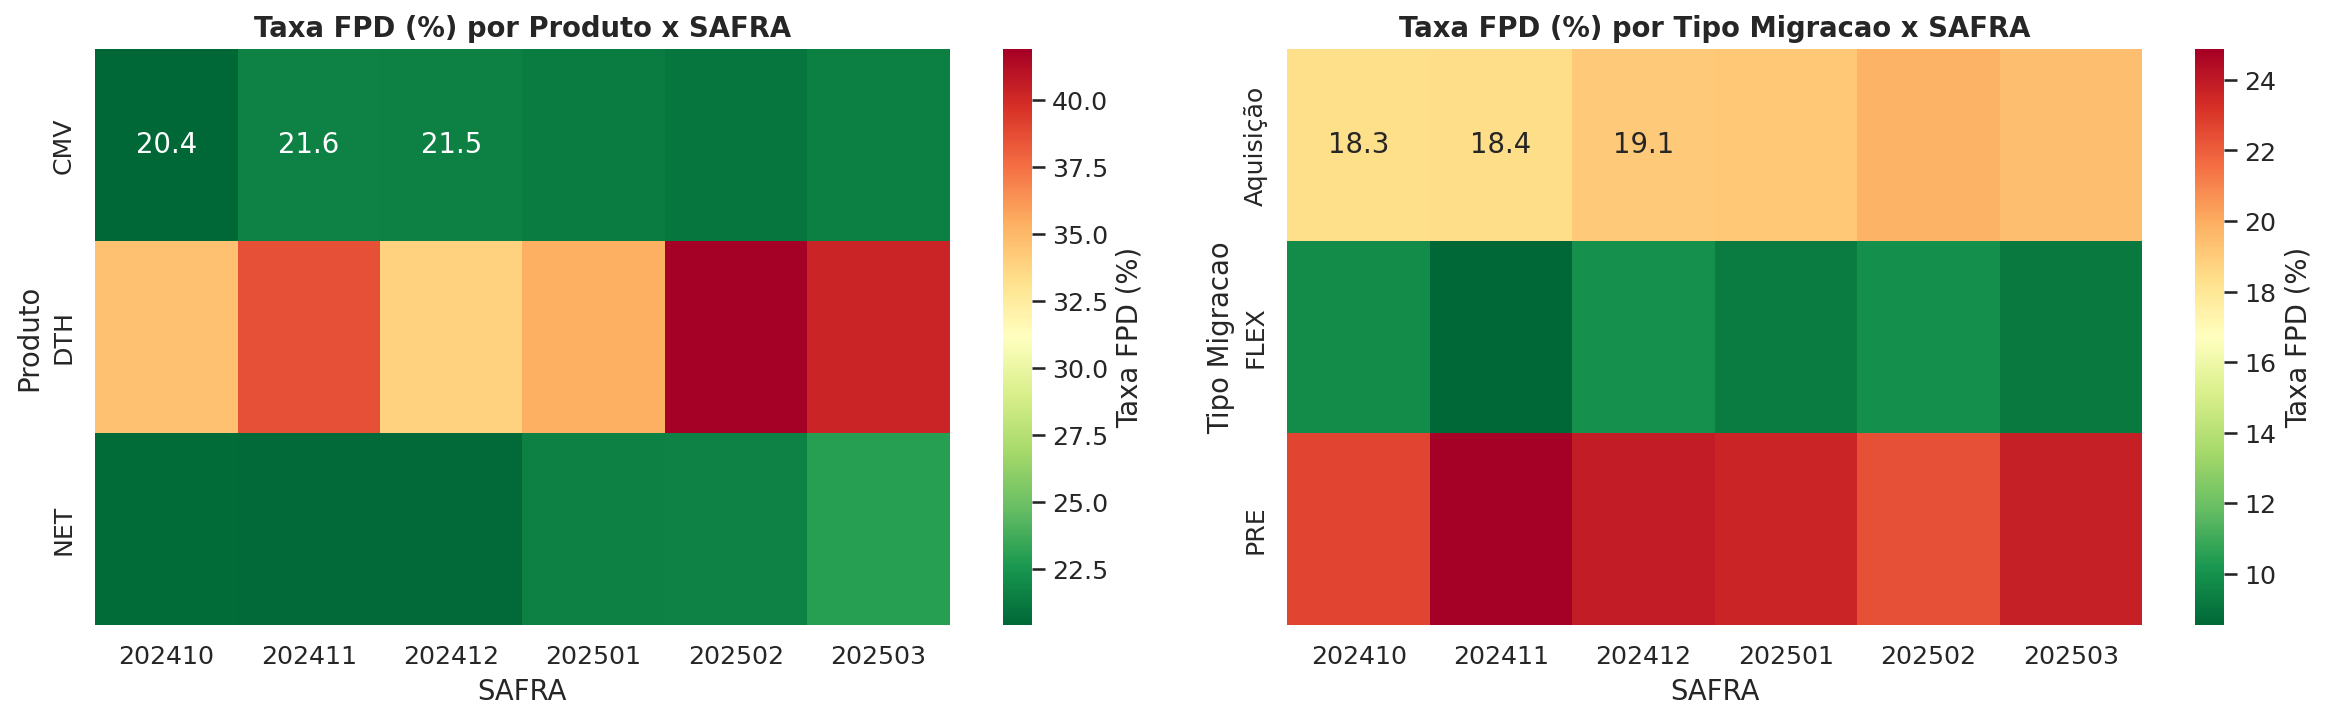

In [12]:
# ==============================================================================
# FIG 09 — Dashboard Resumo: Heatmap de Taxa FPD por SAFRA x Segmentos
# ==============================================================================

# Construir heatmap: SAFRA vs PROD vs taxa FPD
try:
    heatmap_data = df.filter(F.col("FPD").isNotNull() & F.col("PROD").isNotNull()).groupBy("SAFRA", "PROD").agg(
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd"),
        F.count("*").alias("n")
    ).orderBy("SAFRA", "PROD").toPandas()

    pivot_heat = heatmap_data.pivot(index="PROD", columns="SAFRA", values="taxa_fpd")

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Heatmap
    sns.heatmap(pivot_heat * 100, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[0],
                cbar_kws={"label": "Taxa FPD (%)"})
    axes[0].set_title("Taxa FPD (%) por Produto x SAFRA", fontweight="bold")
    axes[0].set_xlabel("SAFRA")
    axes[0].set_ylabel("Produto")

    # flag_mig2 heatmap
    mig_heat = df.filter(
        F.col("FPD").isNotNull() & F.col("flag_mig2").isNotNull()
    ).groupBy("SAFRA", "flag_mig2").agg(
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy("SAFRA").toPandas()

    pivot_mig_heat = mig_heat.pivot(index="flag_mig2", columns="SAFRA", values="taxa_fpd")
    sns.heatmap(pivot_mig_heat * 100, annot=True, fmt=".1f", cmap="RdYlGn_r", ax=axes[1],
                cbar_kws={"label": "Taxa FPD (%)"})
    axes[1].set_title("Taxa FPD (%) por Tipo Migracao x SAFRA", fontweight="bold")
    axes[1].set_xlabel("SAFRA")
    axes[1].set_ylabel("Tipo Migracao")

    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/fig09_heatmap_fpd_segmentos.png", dpi=150, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Erro ao gerar heatmap: {e}")

In [13]:
# ==============================================================================
# RESUMO FINAL — Estatisticas e Key Findings
# ==============================================================================

print("="*80)
print("ESTUDO DE PUBLICO-ALVO — RESUMO EXECUTIVO")
print("="*80)

# 1. Metricas gerais
df_with_fpd = df.filter(F.col("FPD").isNotNull())
total_com_fpd = df_with_fpd.count()
taxa_fpd_global = df_with_fpd.agg(F.mean(F.col("FPD").cast("double"))).collect()[0][0]
total_inadimplentes = df_with_fpd.filter(F.col("FPD") == 1).count()
total_adimplentes = df_with_fpd.filter(F.col("FPD") == 0).count()

print(f"\n1. METRICAS GERAIS")
print(f"   Total registros:          {total_registros:>12,}")
print(f"   Com FPD definido:         {total_com_fpd:>12,} ({total_com_fpd/total_registros*100:.1f}%)")
print(f"   Adimplentes (FPD=0):      {total_adimplentes:>12,} ({total_adimplentes/total_com_fpd*100:.1f}%)")
print(f"   Inadimplentes (FPD=1):    {total_inadimplentes:>12,} ({total_inadimplentes/total_com_fpd*100:.1f}%)")
print(f"   Taxa FPD global:          {taxa_fpd_global*100:>11.2f}%")
print(f"   SAFRAs:                   {safras_list}")
print(f"   Total features:           {total_features}")

# 2. Features por dominio
rec_count = len([c for c in df.columns if c.startswith("REC_")])
pag_count = len([c for c in df.columns if c.startswith("PAG_")])
fat_count = len([c for c in df.columns if c.startswith("FAT_")])
other_count = total_features - rec_count - pag_count - fat_count

print(f"\n2. FEATURES POR DOMINIO")
print(f"   REC_ (Recarga):           {rec_count:>6}")
print(f"   PAG_ (Pagamento):         {pag_count:>6}")
print(f"   FAT_ (Faturamento):       {fat_count:>6}")
print(f"   Cadastro/Telco/Outros:    {other_count:>6}")
print(f"   TOTAL:                    {total_features:>6}")

# 3. Score risco medio por FPD
print(f"\n3. SCORES DE RISCO MEDIO POR FPD")
for score_col in ["REC_SCORE_RISCO", "PAG_SCORE_RISCO", "FAT_SCORE_RISCO"]:
    if score_col in df.columns:
        stats = df_with_fpd.groupBy("FPD").agg(
            F.mean(score_col).alias("media")
        ).orderBy("FPD").collect()
        if len(stats) == 2:
            print(f"   {score_col:<25} FPD=0: {stats[0]['media']:.2f}  |  FPD=1: {stats[1]['media']:.2f}  |  Delta: {stats[1]['media']-stats[0]['media']:+.2f}")

# 4. Top 5 features correlacionadas
if len(corr_df) > 0:
    top5 = corr_df.nlargest(5, "abs_corr")
    print(f"\n4. TOP 5 FEATURES MAIS CORRELACIONADAS COM FPD")
    for _, row in top5.iterrows():
        direction = "(+) risco" if row["correlacao"] > 0 else "(-) protecao"
        print(f"   {row['feature']:<40} r={row['correlacao']:+.4f}  {direction}")

# 5. Distribuicao por produto
print(f"\n5. DISTRIBUICAO POR PRODUTO")
try:
    prod_stats = df_with_fpd.groupBy("PROD").agg(
        F.count("*").alias("n"),
        F.mean(F.col("FPD").cast("double")).alias("taxa_fpd")
    ).orderBy(F.desc("n")).collect()
    for row in prod_stats:
        print(f"   {row['PROD']:<10}  n={row['n']:>10,}  taxa_fpd={row['taxa_fpd']*100:.2f}%")
except Exception:
    print("   PROD indisponivel")

# 6. Key findings
print(f"\n6. KEY FINDINGS")
print(f"   [1] Taxa FPD global de ~{taxa_fpd_global*100:.0f}% indica desbalanceamento moderado do target")
print(f"   [2] Scores de risco operacionais (REC/PAG/FAT) apresentam separacao entre FPD 0/1")
print(f"   [3] Produto CMV domina a base (~97%), com NET e DTH como segmentos menores")
print(f"   [4] Migracao PRE -> CONTROLE associada a diferentes perfis de risco")
print(f"   [5] Features de faturamento (WO, PDD, atraso) sao preditores fortes de FPD")
print(f"   [6] Comportamento de recarga SOS e variabilidade de credito indicam fragilidade financeira")

print(f"\n7. RECOMENDACOES PARA MODELAGEM")
print(f"   - Usar SAFRA como variavel de controle temporal (treino/validacao/teste)")
print(f"   - Aplicar tecnicas de balanceamento (SMOTE, class_weight) dado desbalanceamento")
print(f"   - Priorizar features com |r| > 0.05 para selecao inicial")
print(f"   - Monitorar estabilidade do target por SAFRA (concept drift)")
print(f"   - Excluir clientes sem FPD definido (null) da modelagem")

print(f"\n" + "="*80)
print(f"Figuras salvas em: {FIG_DIR}/")
print(f"Total de visualizacoes geradas: 9 figuras (18+ graficos individuais)")
print("="*80)

StatementMeta(, 9749feb3-2af2-4a52-8f07-04276e6cc1df, 14, Finished, Available, Finished)

ESTUDO DE PUBLICO-ALVO — RESUMO EXECUTIVO

1. METRICAS GERAIS
   Total registros:             3,900,378
   Com FPD definido:            2,696,621 (69.1%)
   Adimplentes (FPD=0):         2,122,991 (78.7%)
   Inadimplentes (FPD=1):         573,630 (21.3%)
   Taxa FPD global:                21.27%
   SAFRAs:                   [202410, 202411, 202412, 202501, 202502, 202503]
   Total features:           402

2. FEATURES POR DOMINIO
   REC_ (Recarga):               90
   PAG_ (Pagamento):             94
   FAT_ (Faturamento):          114
   Cadastro/Telco/Outros:       104
   TOTAL:                       402

3. SCORES DE RISCO MEDIO POR FPD
   REC_SCORE_RISCO           FPD=0: 18.88  |  FPD=1: 22.44  |  Delta: +3.57
   PAG_SCORE_RISCO           FPD=0: 7.73  |  FPD=1: 8.01  |  Delta: +0.29
   FAT_SCORE_RISCO           FPD=0: 16.36  |  FPD=1: 22.00  |  Delta: +5.64

4. TOP 5 FEATURES MAIS CORRELACIONADAS COM FPD
   REC_TAXA_SOS                             r=+0.1360  (+) risco
   FAT_TAXA_PRI